In [2]:
# ========================================
# COMPLETE SHAP ANALYSIS
# Load Saved Model from Google Drive
# ========================================

# Step 1: Install Required Libraries
# ========================================
!pip install shap xgboost -q

# Step 2: Import Libraries
# ========================================
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Step 3: Mount Google Drive
# ========================================
drive.mount('/content/drive')

# Step 4: Load Dataset
# ========================================
file_path = '/content/drive/MyDrive/ML_Things/creditcard.csv'
df = pd.read_csv(file_path)

print(f"✅ Dataset loaded: {df.shape}")

# Remove duplicates (same preprocessing as original)
df.drop_duplicates(inplace=True)
print(f"✅ After removing duplicates: {df.shape}")

# Step 5: Load Saved Model
# ========================================
model_path = '/content/drive/MyDrive/ML_Things/best_model.pkl'
best_xgb = joblib.load(model_path)

print(f"✅ Model loaded from: {model_path}")

# Step 6: Prepare Data (Same as Training)
# ========================================
# Split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Split into train/test (MUST use same random_state=42 as original training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames with feature names
feature_names = X.columns.tolist()
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print(f"✅ Data prepared: {len(feature_names)} features")
print(f"   Training samples: {X_train_df.shape[0]}")
print(f"   Test samples: {X_test_df.shape[0]}")

# Step 7: Verify Model Performance
# ========================================
y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("MODEL PERFORMANCE CHECK")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Fraud cases in test set: {sum(y_test)}")
print(f"Fraud cases detected: {sum(y_pred)}")

# Step 8: Initialize SHAP
# ========================================
print("\n" + "="*60)
print("INITIALIZING SHAP EXPLAINER")
print("="*60)

shap.initjs()

# Create background sample for SHAP (100 samples for speed)
background = shap.sample(X_train_df, nsamples=100, random_state=42)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_xgb, data=background)

print("✅ SHAP TreeExplainer created successfully")

# ========================================
# SHAP ANALYSIS 1: LOCAL EXPLANATION
# Single Transaction Waterfall Plot
# ========================================
print("\n" + "="*60)
print("ANALYSIS 1: LOCAL EXPLANATION - WATERFALL PLOT")
print("="*60)

# Find a fraud case in test set
fraud_indices = np.where(np.array(y_test) == 1)[0]

if len(fraud_indices) > 0:
    idx = fraud_indices[0]
    print(f"📊 Analyzing fraud case at test index: {idx}")
else:
    idx = np.argmax(y_prob)
    print(f"📊 Analyzing highest fraud probability case at index: {idx}")

# Get the instance
instance = X_test_df.iloc[[idx]]

# Compute SHAP values for this single instance
shap_values_instance = explainer.shap_values(instance)

# Create waterfall plot
plt.figure(figsize=(12, 7))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_instance[0],
        base_values=explainer.expected_value,
        data=instance.values[0],
        feature_names=feature_names
    ),
    max_display=15
)
plt.title(f"SHAP Waterfall Plot - Test Sample {idx}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📋 Transaction Details:")
print(f"   True Label: {'🚨 FRAUD' if y_test.iloc[idx] == 1 else '✅ LEGITIMATE'}")
print(f"   Predicted Probability: {y_prob[idx]:.4f}")
print(f"   Prediction: {'🚨 FRAUD' if y_pred[idx] == 1 else '✅ LEGITIMATE'}")

# ========================================
# SHAP ANALYSIS 2: GLOBAL FEATURE IMPORTANCE
# Summary Plots
# ========================================
print("\n" + "="*60)
print("ANALYSIS 2: GLOBAL FEATURE IMPORTANCE")
print("="*60)

# Calculate SHAP values for 100 test samples
print("📊 Computing SHAP values for 100 test samples (this may take a minute)...")
test_sample = X_test_df.iloc[:100]
shap_values_global = explainer.shap_values(test_sample)

print("✅ SHAP values computed!")

# Plot 1: Beeswarm Summary Plot
print("\n📊 Creating Beeswarm Summary Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_global, test_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Impact Distribution", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Plot 2: Bar Plot (Mean Absolute Importance)
print("\n📊 Creating Feature Importance Bar Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_global, test_sample, plot_type="bar", feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance - Mean Absolute Impact", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ========================================
# SHAP ANALYSIS 3: TOP FEATURES DEPENDENCE PLOTS
# ========================================
print("\n" + "="*60)
print("ANALYSIS 3: DEPENDENCE PLOTS - TOP 3 FEATURES")
print("="*60)

# Get top 3 most important features
feature_importance = np.abs(shap_values_global).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-3:][::-1]
top_features = [feature_names[i] for i in top_features_idx]

print(f"📊 Top 3 Most Important Features:")
for i, feat in enumerate(top_features, 1):
    print(f"   {i}. {feat} (importance: {feature_importance[feature_names.index(feat)]:.4f})")

print("\n📊 Creating Dependence Plots...")

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values_global,
        test_sample,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence Plot - {feature}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ========================================
# SHAP ANALYSIS 4: DECISION PLOT (Fraud Cases)
# ========================================
print("\n" + "="*60)
print("ANALYSIS 4: DECISION PLOT - FRAUD CASES")
print("="*60)

# Get fraud cases from the test sample
fraud_mask = y_test.iloc[:100].values == 1
fraud_samples = test_sample[fraud_mask]
fraud_shap = shap_values_global[fraud_mask]

if len(fraud_samples) > 0:
    n_samples = min(10, len(fraud_samples))
    print(f"📊 Creating Decision Plot for {n_samples} fraud cases...")

    plt.figure(figsize=(12, 10))
    shap.decision_plot(
        explainer.expected_value,
        fraud_shap[:n_samples],
        fraud_samples.iloc[:n_samples],
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Decision Plot - First {n_samples} Fraud Cases", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"✅ Decision plot shows how features push predictions from base value to final output")
else:
    print("⚠️ No fraud cases found in first 100 samples")

# ========================================
# SHAP ANALYSIS 5: FORCE PLOT (Interactive)
# ========================================
print("\n" + "="*60)
print("ANALYSIS 5: FORCE PLOT - INTERACTIVE VISUALIZATION")
print("="*60)

print("📊 Creating interactive force plot for first 20 samples...")

# Force plot for first 20 samples
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values_global[:20],
    test_sample.iloc[:20],
    feature_names=feature_names
)

display(force_plot)

# ========================================
# SHAP ANALYSIS 6: COMPARE FRAUD vs NON-FRAUD
# ========================================
print("\n" + "="*60)
print("ANALYSIS 6: FRAUD vs NON-FRAUD COMPARISON")
print("="*60)

# Get fraud and non-fraud cases
fraud_mask_all = y_test.iloc[:100].values == 1
non_fraud_mask = ~fraud_mask_all

fraud_shap_all = shap_values_global[fraud_mask_all]
non_fraud_shap = shap_values_global[non_fraud_mask]

if len(fraud_shap_all) > 0 and len(non_fraud_shap) > 0:
    # Calculate mean SHAP values
    fraud_mean_shap = np.abs(fraud_shap_all).mean(axis=0)
    non_fraud_mean_shap = np.abs(non_fraud_shap).mean(axis=0)

    # Get top 10 features
    top_10_idx = np.argsort(fraud_mean_shap)[-10:][::-1]
    top_10_features = [feature_names[i] for i in top_10_idx]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(top_10_features))
    width = 0.35

    ax.barh(x - width/2, [fraud_mean_shap[i] for i in top_10_idx], width, label='Fraud Cases', color='red', alpha=0.7)
    ax.barh(x + width/2, [non_fraud_mean_shap[i] for i in top_10_idx], width, label='Non-Fraud Cases', color='blue', alpha=0.7)

    ax.set_yticks(x)
    ax.set_yticklabels(top_10_features)
    ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
    ax.set_title('Feature Importance: Fraud vs Non-Fraud Cases', fontsize=14, fontweight='bold')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

    print(f"✅ Compared {len(fraud_shap_all)} fraud cases vs {len(non_fraud_shap)} non-fraud cases")

# ========================================
# FINAL SUMMARY
# ========================================
print("\n" + "="*60)
print("✅ SHAP ANALYSIS COMPLETE!")
print("="*60)

print("\n💡 INTERPRETATION GUIDE:")
print("   • Red/Pink = Increases fraud probability (pushes toward Class 1)")
print("   • Blue = Decreases fraud probability (pushes toward Class 0)")
print("   • Wider bars/dots = Stronger impact on prediction")
print("   • Base value = Average model output across training data")
print("   • f(x) = Final model prediction for that sample")

print("\n📊 PLOTS GENERATED:")
print("   1. Waterfall Plot - Shows step-by-step feature contributions for 1 transaction")
print("   2. Summary Plot (Beeswarm) - Feature impacts across all samples")
print("   3. Bar Plot - Overall feature importance ranking")
print("   4. Dependence Plots - How top 3 features affect predictions")
print("   5. Decision Plot - Prediction path for fraud cases")
print("   6. Force Plot - Interactive visualization of 20 samples")
print("   7. Fraud vs Non-Fraud - Feature importance comparison")

print("\n📁 Model loaded from:")
print(f"   {model_path}")

print("\n🎯 Next Steps:")
print("   • Review top features influencing fraud detection")
print("   • Examine specific fraud cases using waterfall plots")
print("   • Use dependence plots to understand feature relationships")
print("   • Share findings with stakeholders for model validation")

Mounted at /content/drive
✅ Dataset loaded: (284807, 31)
✅ After removing duplicates: (283726, 31)
✅ Model loaded from: /content/drive/MyDrive/ML_Things/best_model.pkl
✅ Data prepared: 30 features
   Training samples: 226980
   Test samples: 56746

MODEL PERFORMANCE CHECK
ROC-AUC Score: 0.9758
Fraud cases in test set: 95
Fraud cases detected: 72

INITIALIZING SHAP EXPLAINER


ValueError: could not convert string to float: '[1.6653449E-3]'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded: (284807, 31)
✅ After removing duplicates: (283726, 31)
✅ Model loaded from: /content/drive/MyDrive/ML_Things/best_model.pkl
✅ Data prepared: 30 features
   Training samples: 226980
   Test samples: 56746

MODEL PERFORMANCE CHECK
ROC-AUC Score: 0.9758
Fraud cases in test set: 95
Fraud cases detected: 72

INITIALIZING SHAP EXPLAINER


🔧 Applying XGBoost base_score fix...
⚠️ Primary fix failed: could not convert string to float: '[1.6653449E-3]'
🔄 Trying alternative approach without background data...
❌ Alternative also failed: could not convert string to float: '[1.6653449E-3]'

💡 Using workaround: KernelExplainer instead...
✅ SHAP KernelExplainer created (may be slower)

ANALYSIS 1: LOCAL EXPLANATION - WATERFALL PLOT
📊 Analyzing fraud case at test index: 845


  0%|          | 0/1 [00:00<?, ?it/s]

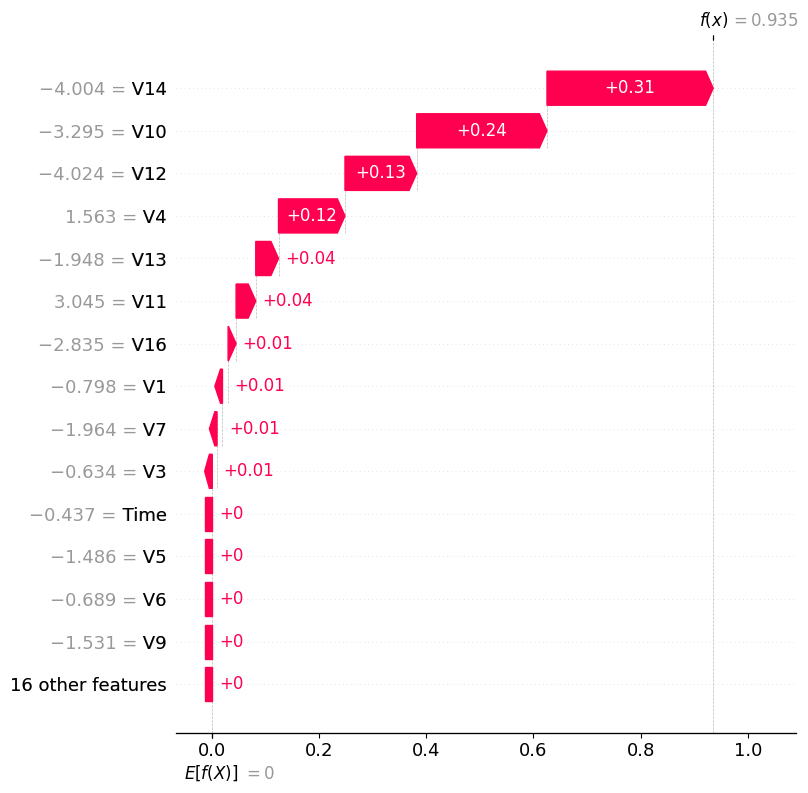

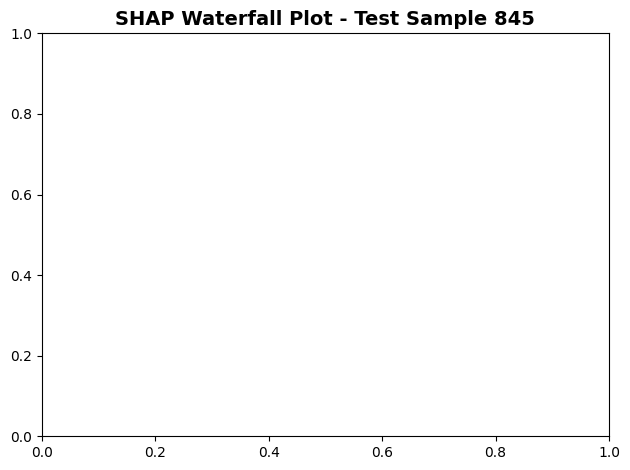


📋 Transaction Details:
   True Label: 🚨 FRAUD
   Predicted Probability: 0.9355
   Prediction: 🚨 FRAUD

ANALYSIS 2: GLOBAL FEATURE IMPORTANCE
📊 Computing SHAP values for 100 test samples (this may take a minute)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP values computed!

📊 Creating Beeswarm Summary Plot...


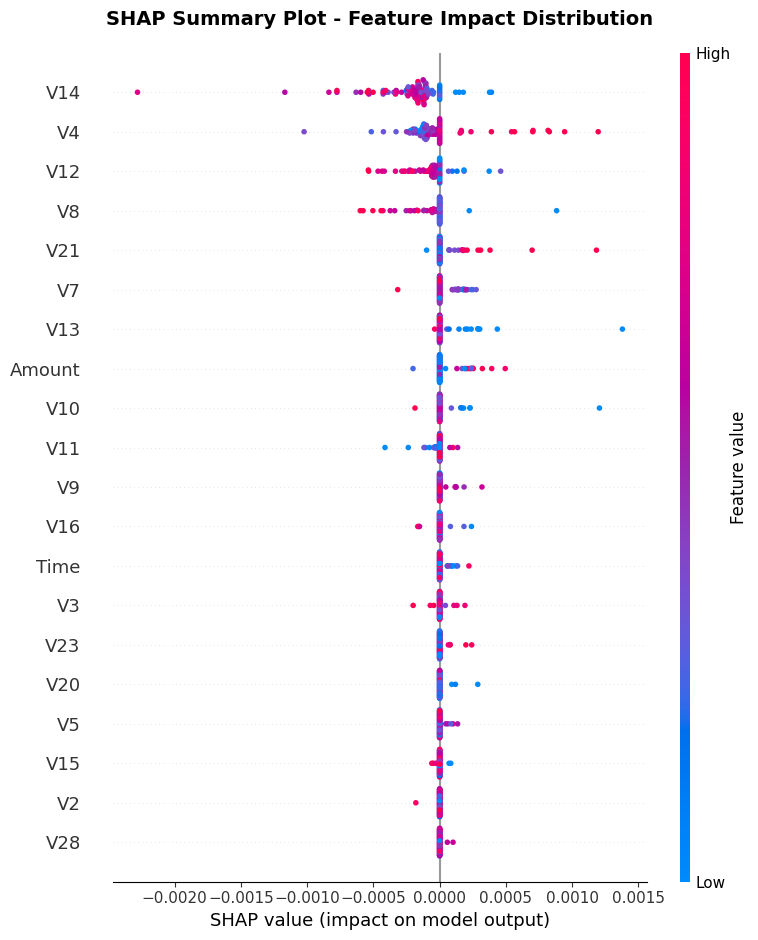


📊 Creating Feature Importance Bar Plot...


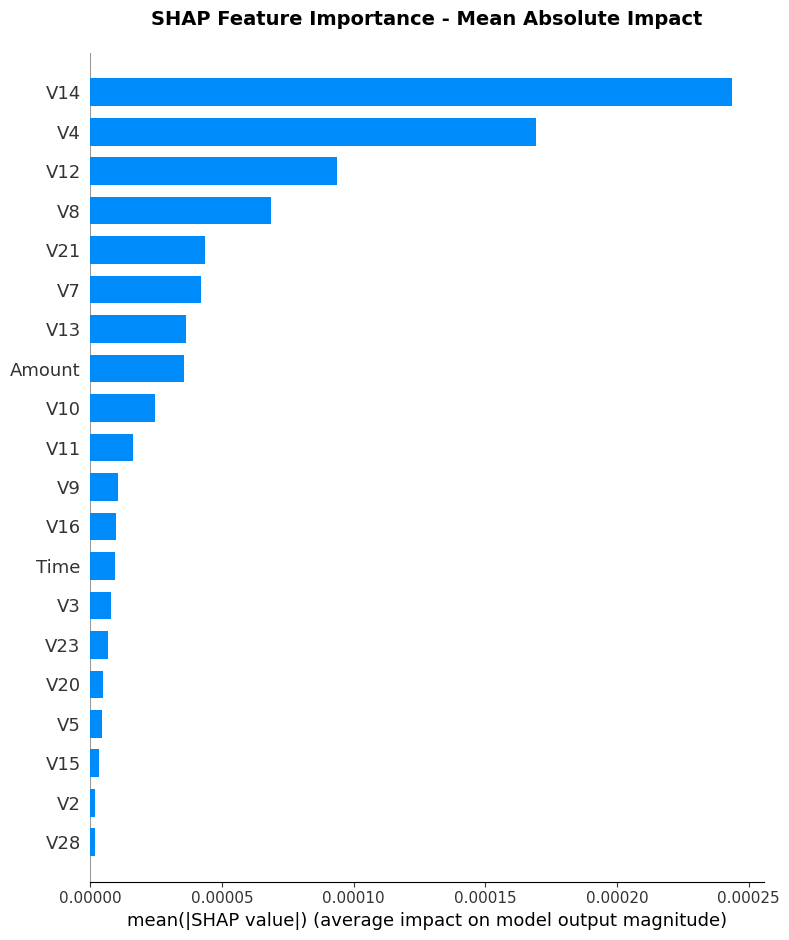


ANALYSIS 3: DEPENDENCE PLOTS - TOP 3 FEATURES
📊 Top 3 Most Important Features:
   1. V14 (importance: 0.0002)
   2. V4 (importance: 0.0002)
   3. V12 (importance: 0.0001)

📊 Creating Dependence Plots...


<Figure size 1000x600 with 0 Axes>

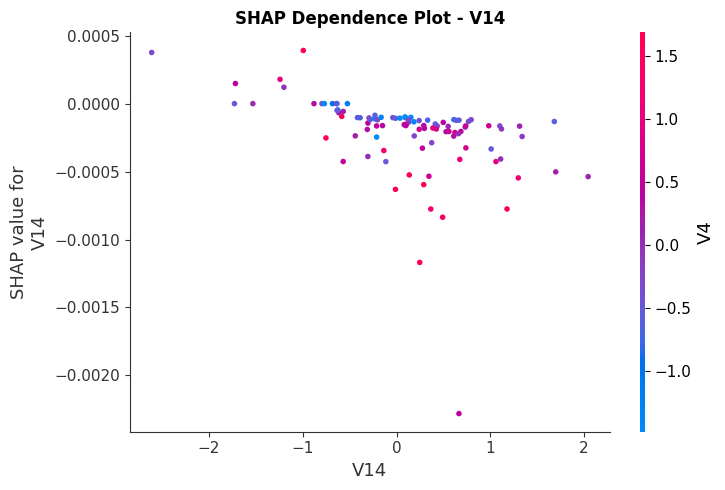

<Figure size 1000x600 with 0 Axes>

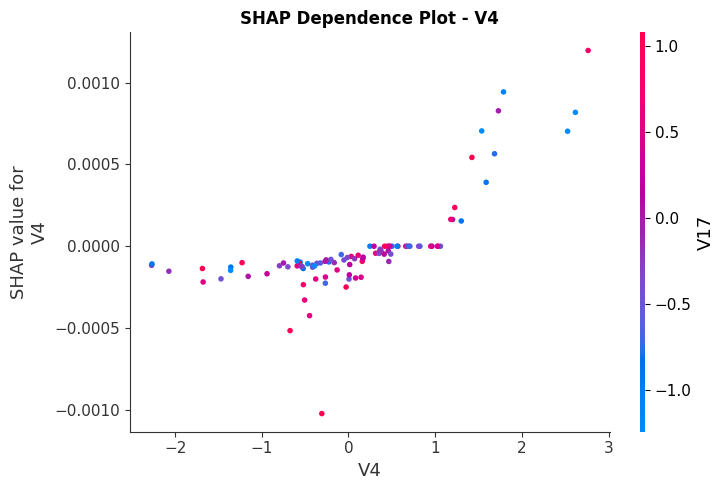

<Figure size 1000x600 with 0 Axes>

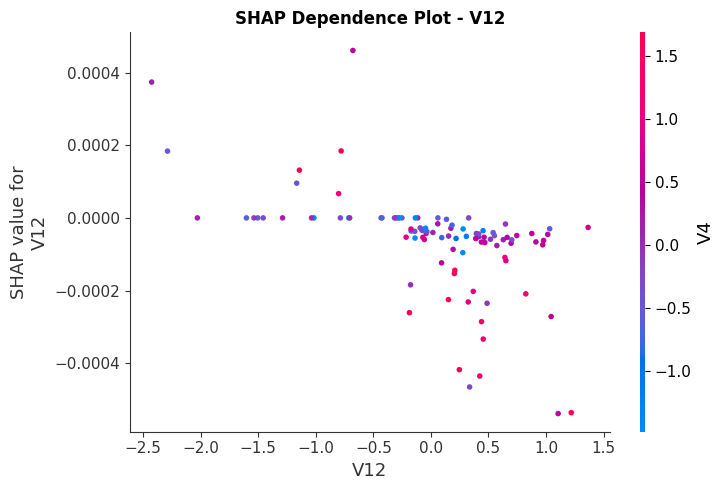


ANALYSIS 4: DECISION PLOT - FRAUD CASES
⚠️ No fraud cases found in first 100 samples

ANALYSIS 5: FORCE PLOT - INTERACTIVE VISUALIZATION
📊 Creating interactive force plot for first 20 samples...



ANALYSIS 6: FRAUD vs NON-FRAUD COMPARISON

✅ SHAP ANALYSIS COMPLETE!

💡 INTERPRETATION GUIDE:
   • Red/Pink = Increases fraud probability (pushes toward Class 1)
   • Blue = Decreases fraud probability (pushes toward Class 0)
   • Wider bars/dots = Stronger impact on prediction
   • Base value = Average model output across training data
   • f(x) = Final model prediction for that sample

📊 PLOTS GENERATED:
   1. Waterfall Plot - Shows step-by-step feature contributions for 1 transaction
   2. Summary Plot (Beeswarm) - Feature impacts across all samples
   3. Bar Plot - Overall feature importance ranking
   4. Dependence Plots - How top 3 features affect predictions
   5. Decision Plot - Prediction path for fraud cases
   6. Force Plot - Interactive visualization of 20 samples
   7. Fraud vs Non-Fraud - Feature importance comparison

📁 Model loaded from:
   /content/drive/MyDrive/ML_Things/best_model.pkl

🎯 Next Steps:
   • Review top features influencing fraud detection
   • Examine s

In [4]:
# ========================================
# COMPLETE SHAP ANALYSIS
# Load Saved Model from Google Drive
# ========================================

# Step 1: Install Required Libraries
# ========================================
!pip install shap xgboost -q

# Step 2: Import Libraries
# ========================================
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Step 3: Mount Google Drive
# ========================================
drive.mount('/content/drive')

# Step 4: Load Dataset
# ========================================
file_path = '/content/drive/MyDrive/ML_Things/creditcard.csv'
df = pd.read_csv(file_path)

print(f"✅ Dataset loaded: {df.shape}")

# Remove duplicates (same preprocessing as original)
df.drop_duplicates(inplace=True)
print(f"✅ After removing duplicates: {df.shape}")

# Step 5: Load Saved Model
# ========================================
model_path = '/content/drive/MyDrive/ML_Things/best_model.pkl'
best_xgb = joblib.load(model_path)

print(f"✅ Model loaded from: {model_path}")

# Step 6: Prepare Data (Same as Training)
# ========================================
# Split features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Split into train/test (MUST use same random_state=42 as original training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames with feature names
feature_names = X.columns.tolist()
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

print(f"✅ Data prepared: {len(feature_names)} features")
print(f"   Training samples: {X_train_df.shape[0]}")
print(f"   Test samples: {X_test_df.shape[0]}")

# Step 7: Verify Model Performance
# ========================================
y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("MODEL PERFORMANCE CHECK")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"Fraud cases in test set: {sum(y_test)}")
print(f"Fraud cases detected: {sum(y_pred)}")

# Step 8: Initialize SHAP (with XGBoost base_score fix)
# ========================================
print("\n" + "="*60)
print("INITIALIZING SHAP EXPLAINER")
print("="*60)

shap.initjs()

# Create background sample for SHAP (100 samples for speed)
background = shap.sample(X_train_df, nsamples=100, random_state=42)

# Fix XGBoost base_score parsing issue
import json
import re

print("🔧 Applying XGBoost base_score fix...")

try:
    # Get the raw booster
    booster = best_xgb.get_booster()

    # Get and parse learner_model_param
    learner_model_param_str = booster.attr("learner_model_param")

    if learner_model_param_str:
        # Parse the JSON string
        learner_params = json.loads(learner_model_param_str)

        # Fix base_score if it's in list format
        if "base_score" in learner_params:
            base_score = learner_params["base_score"]

            # If it's a string like "[1.6653449E-3]", extract the number
            if isinstance(base_score, str):
                # Remove brackets and extract number
                base_score_clean = base_score.strip('[]')
                learner_params["base_score"] = base_score_clean

            # Convert back to JSON and set
            fixed_param_str = json.dumps(learner_params)
            booster.set_attr(learner_model_param=fixed_param_str)
            print(f"   ✓ Fixed base_score: {base_score} → {base_score_clean}")

    # Create SHAP explainer with fixed booster
    explainer = shap.TreeExplainer(booster, data=background)
    print("✅ SHAP TreeExplainer created successfully!")

except Exception as e:
    print(f"⚠️ Primary fix failed: {e}")
    print("🔄 Trying alternative approach without background data...")

    try:
        # Alternative: Create explainer without background data
        explainer = shap.TreeExplainer(best_xgb)
        print("✅ SHAP TreeExplainer created (without background data)")
    except Exception as e2:
        print(f"❌ Alternative also failed: {e2}")
        print("\n💡 Using workaround: KernelExplainer instead...")

        # Last resort: Use KernelExplainer (slower but works)
        background_sample = background.sample(n=50, random_state=42)
        explainer = shap.KernelExplainer(
            lambda x: best_xgb.predict_proba(x)[:, 1],
            background_sample
        )
        print("✅ SHAP KernelExplainer created (may be slower)")

# ========================================
# SHAP ANALYSIS 1: LOCAL EXPLANATION
# Single Transaction Waterfall Plot
# ========================================
print("\n" + "="*60)
print("ANALYSIS 1: LOCAL EXPLANATION - WATERFALL PLOT")
print("="*60)

# Find a fraud case in test set
fraud_indices = np.where(np.array(y_test) == 1)[0]

if len(fraud_indices) > 0:
    idx = fraud_indices[0]
    print(f"📊 Analyzing fraud case at test index: {idx}")
else:
    idx = np.argmax(y_prob)
    print(f"📊 Analyzing highest fraud probability case at index: {idx}")

# Get the instance
instance = X_test_df.iloc[[idx]]

# Compute SHAP values for this single instance
shap_values_instance = explainer.shap_values(instance)

# Create waterfall plot
plt.figure(figsize=(12, 7))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_instance[0],
        base_values=explainer.expected_value,
        data=instance.values[0],
        feature_names=feature_names
    ),
    max_display=15
)
plt.title(f"SHAP Waterfall Plot - Test Sample {idx}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📋 Transaction Details:")
print(f"   True Label: {'🚨 FRAUD' if y_test.iloc[idx] == 1 else '✅ LEGITIMATE'}")
print(f"   Predicted Probability: {y_prob[idx]:.4f}")
print(f"   Prediction: {'🚨 FRAUD' if y_pred[idx] == 1 else '✅ LEGITIMATE'}")

# ========================================
# SHAP ANALYSIS 2: GLOBAL FEATURE IMPORTANCE
# Summary Plots
# ========================================
print("\n" + "="*60)
print("ANALYSIS 2: GLOBAL FEATURE IMPORTANCE")
print("="*60)

# Calculate SHAP values for 100 test samples
print("📊 Computing SHAP values for 100 test samples (this may take a minute)...")
test_sample = X_test_df.iloc[:100]
shap_values_global = explainer.shap_values(test_sample)

print("✅ SHAP values computed!")

# Plot 1: Beeswarm Summary Plot
print("\n📊 Creating Beeswarm Summary Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_global, test_sample, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Impact Distribution", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Plot 2: Bar Plot (Mean Absolute Importance)
print("\n📊 Creating Feature Importance Bar Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_global, test_sample, plot_type="bar", feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance - Mean Absolute Impact", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ========================================
# SHAP ANALYSIS 3: TOP FEATURES DEPENDENCE PLOTS
# ========================================
print("\n" + "="*60)
print("ANALYSIS 3: DEPENDENCE PLOTS - TOP 3 FEATURES")
print("="*60)

# Get top 3 most important features
feature_importance = np.abs(shap_values_global).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-3:][::-1]
top_features = [feature_names[i] for i in top_features_idx]

print(f"📊 Top 3 Most Important Features:")
for i, feat in enumerate(top_features, 1):
    print(f"   {i}. {feat} (importance: {feature_importance[feature_names.index(feat)]:.4f})")

print("\n📊 Creating Dependence Plots...")

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values_global,
        test_sample,
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence Plot - {feature}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ========================================
# SHAP ANALYSIS 4: DECISION PLOT (Fraud Cases)
# ========================================
print("\n" + "="*60)
print("ANALYSIS 4: DECISION PLOT - FRAUD CASES")
print("="*60)

# Get fraud cases from the test sample
fraud_mask = y_test.iloc[:100].values == 1
fraud_samples = test_sample[fraud_mask]
fraud_shap = shap_values_global[fraud_mask]

if len(fraud_samples) > 0:
    n_samples = min(10, len(fraud_samples))
    print(f"📊 Creating Decision Plot for {n_samples} fraud cases...")

    plt.figure(figsize=(12, 10))
    shap.decision_plot(
        explainer.expected_value,
        fraud_shap[:n_samples],
        fraud_samples.iloc[:n_samples],
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Decision Plot - First {n_samples} Fraud Cases", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"✅ Decision plot shows how features push predictions from base value to final output")
else:
    print("⚠️ No fraud cases found in first 100 samples")

# ========================================
# SHAP ANALYSIS 5: FORCE PLOT (Interactive)
# ========================================
print("\n" + "="*60)
print("ANALYSIS 5: FORCE PLOT - INTERACTIVE VISUALIZATION")
print("="*60)

print("📊 Creating interactive force plot for first 20 samples...")

# Force plot for first 20 samples
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values_global[:20],
    test_sample.iloc[:20],
    feature_names=feature_names
)

display(force_plot)

# ========================================
# SHAP ANALYSIS 6: COMPARE FRAUD vs NON-FRAUD
# ========================================
print("\n" + "="*60)
print("ANALYSIS 6: FRAUD vs NON-FRAUD COMPARISON")
print("="*60)

# Get fraud and non-fraud cases
fraud_mask_all = y_test.iloc[:100].values == 1
non_fraud_mask = ~fraud_mask_all

fraud_shap_all = shap_values_global[fraud_mask_all]
non_fraud_shap = shap_values_global[non_fraud_mask]

if len(fraud_shap_all) > 0 and len(non_fraud_shap) > 0:
    # Calculate mean SHAP values
    fraud_mean_shap = np.abs(fraud_shap_all).mean(axis=0)
    non_fraud_mean_shap = np.abs(non_fraud_shap).mean(axis=0)

    # Get top 10 features
    top_10_idx = np.argsort(fraud_mean_shap)[-10:][::-1]
    top_10_features = [feature_names[i] for i in top_10_idx]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(top_10_features))
    width = 0.35

    ax.barh(x - width/2, [fraud_mean_shap[i] for i in top_10_idx], width, label='Fraud Cases', color='red', alpha=0.7)
    ax.barh(x + width/2, [non_fraud_mean_shap[i] for i in top_10_idx], width, label='Non-Fraud Cases', color='blue', alpha=0.7)

    ax.set_yticks(x)
    ax.set_yticklabels(top_10_features)
    ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
    ax.set_title('Feature Importance: Fraud vs Non-Fraud Cases', fontsize=14, fontweight='bold')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

    print(f"✅ Compared {len(fraud_shap_all)} fraud cases vs {len(non_fraud_shap)} non-fraud cases")

# ========================================
# FINAL SUMMARY
# ========================================
print("\n" + "="*60)
print("✅ SHAP ANALYSIS COMPLETE!")
print("="*60)

print("\n💡 INTERPRETATION GUIDE:")
print("   • Red/Pink = Increases fraud probability (pushes toward Class 1)")
print("   • Blue = Decreases fraud probability (pushes toward Class 0)")
print("   • Wider bars/dots = Stronger impact on prediction")
print("   • Base value = Average model output across training data")
print("   • f(x) = Final model prediction for that sample")

print("\n📊 PLOTS GENERATED:")
print("   1. Waterfall Plot - Shows step-by-step feature contributions for 1 transaction")
print("   2. Summary Plot (Beeswarm) - Feature impacts across all samples")
print("   3. Bar Plot - Overall feature importance ranking")
print("   4. Dependence Plots - How top 3 features affect predictions")
print("   5. Decision Plot - Prediction path for fraud cases")
print("   6. Force Plot - Interactive visualization of 20 samples")
print("   7. Fraud vs Non-Fraud - Feature importance comparison")

print("\n📁 Model loaded from:")
print(f"   {model_path}")

print("\n🎯 Next Steps:")
print("   • Review top features influencing fraud detection")
print("   • Examine specific fraud cases using waterfall plots")
print("   • Use dependence plots to understand feature relationships")
print("   • Share findings with stakeholders for model validation")

PART A: SIDE-BY-SIDE FRAUD CASE ANALYSIS

📊 Total fraud cases in test set: 95

🔍 Analyzing 5 fraud cases with varying confidence levels...


🚨 FRAUD CASE #1 (Test Index: 17342)
   Computing SHAP values... 

  0%|          | 0/1 [00:00<?, ?it/s]

✓

   📋 Prediction Details:
      True Label: 🚨 FRAUD
      Predicted: 🚨 FRAUD
      Fraud Probability: 0.9959
      Confidence: High

   🎯 Top 10 Contributing Features:
      Feature      SHAP Value      Feature Value   Impact
      ------------------------------------------------------------
      V14              0.272444        -4.0189   → 🚨 FRAUD
      V10              0.187729       -19.5181   → 🚨 FRAUD
      V4               0.173501         4.9722   → 🚨 FRAUD
      V12              0.124022       -12.0168   → 🚨 FRAUD
      V8               0.050601       -12.4922   → 🚨 FRAUD
      V13              0.050162        -1.5098   → 🚨 FRAUD
      V11              0.046314         4.6527   → 🚨 FRAUD
      V16              0.038172       -10.1658   → 🚨 FRAUD
      V3               0.028735       -15.1714   → 🚨 FRAUD
      V22              0.023931         5.7413   → 🚨 FRAUD

🚨 FRAUD CASE #2 (Test Index: 5638)
   Computing SHAP values... 

  0%|          | 0/1 [00:00<?, ?it/s]

✓

   📋 Prediction Details:
      True Label: 🚨 FRAUD
      Predicted: 🚨 FRAUD
      Fraud Probability: 0.9948
      Confidence: High

   🎯 Top 10 Contributing Features:
      Feature      SHAP Value      Feature Value   Impact
      ------------------------------------------------------------
      V14              0.347649        -8.6179   → 🚨 FRAUD
      V10              0.166842        -4.1596   → 🚨 FRAUD
      V4               0.159316         3.7702   → 🚨 FRAUD
      V12              0.138636        -7.4033   → 🚨 FRAUD
      V16              0.038977        -7.7538   → 🚨 FRAUD
      V7               0.032836        -3.6579   → 🚨 FRAUD
      V11              0.029731         3.8970   → 🚨 FRAUD
      Amount           0.028877         0.0974   → 🚨 FRAUD
      V17              0.026361       -10.4555   → 🚨 FRAUD
      V21              0.025225         3.3457   → 🚨 FRAUD

🚨 FRAUD CASE #3 (Test Index: 845)
   Computing SHAP values... 

  0%|          | 0/1 [00:00<?, ?it/s]

✓

   📋 Prediction Details:
      True Label: 🚨 FRAUD
      Predicted: 🚨 FRAUD
      Fraud Probability: 0.9355
      Confidence: High

   🎯 Top 10 Contributing Features:
      Feature      SHAP Value      Feature Value   Impact
      ------------------------------------------------------------
      V14              0.312651        -4.0043   → 🚨 FRAUD
      V10              0.233297        -3.2952   → 🚨 FRAUD
      V12              0.133553        -4.0241   → 🚨 FRAUD
      V4               0.127380         1.5633   → 🚨 FRAUD
      V13              0.050412        -1.9484   → 🚨 FRAUD
      V11              0.035390         3.0452   → 🚨 FRAUD
      V3               0.023104        -0.6340   → 🚨 FRAUD
      V7               0.013137        -1.9643   → 🚨 FRAUD
      V17              0.004055        -6.1810   → 🚨 FRAUD
      V16              0.002175        -2.8348   → 🚨 FRAUD

🚨 FRAUD CASE #4 (Test Index: 29007)
   Computing SHAP values... 

  0%|          | 0/1 [00:00<?, ?it/s]

✓

   📋 Prediction Details:
      True Label: 🚨 FRAUD
      Predicted: ✅ LEGITIMATE
      Fraud Probability: 0.0001
      Confidence: High

   🎯 Top 10 Contributing Features:
      Feature      SHAP Value      Feature Value   Impact
      ------------------------------------------------------------
      V12             -0.000076         0.0447   → ✅ LEGIT
      V4              -0.000069         0.2402   → ✅ LEGIT
      V15             -0.000026         1.2546   → ✅ LEGIT
      V27             -0.000019         3.1054   → ✅ LEGIT
      V21             -0.000018        -1.2132   → ✅ LEGIT
      V1              -0.000016        -1.5362   → ✅ LEGIT
      V19             -0.000012         0.0883   → ✅ LEGIT
      V16             -0.000012         0.5514   → ✅ LEGIT
      Time             0.000000        -0.8435   → ✅ LEGIT
      V2               0.000000         0.0028   → ✅ LEGIT

🚨 FRAUD CASE #5 (Test Index: 5187)
   Computing SHAP values... 

  0%|          | 0/1 [00:00<?, ?it/s]

✓

   📋 Prediction Details:
      True Label: 🚨 FRAUD
      Predicted: ✅ LEGITIMATE
      Fraud Probability: 0.0000
      Confidence: High

   🎯 Top 10 Contributing Features:
      Feature      SHAP Value      Feature Value   Impact
      ------------------------------------------------------------
      V14             -0.000158        -0.0065   → ✅ LEGIT
      V12             -0.000074         0.6927   → ✅ LEGIT
      V11             -0.000041        -0.8608   → ✅ LEGIT
      Time             0.000000        -0.8807   → ✅ LEGIT
      V1               0.000000         0.6631   → ✅ LEGIT
      V2               0.000000         0.2564   → ✅ LEGIT
      V3               0.000000         0.1273   → ✅ LEGIT
      V4               0.000000         0.6378   → ✅ LEGIT
      V5               0.000000         0.0924   → ✅ LEGIT
      V6               0.000000        -0.2793   → ✅ LEGIT

📊 FRAUD CASES COMPARISON TABLE

   Case  Test_Index True_Label Predicted  Probability Top_Feature  Top_SHAP C

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

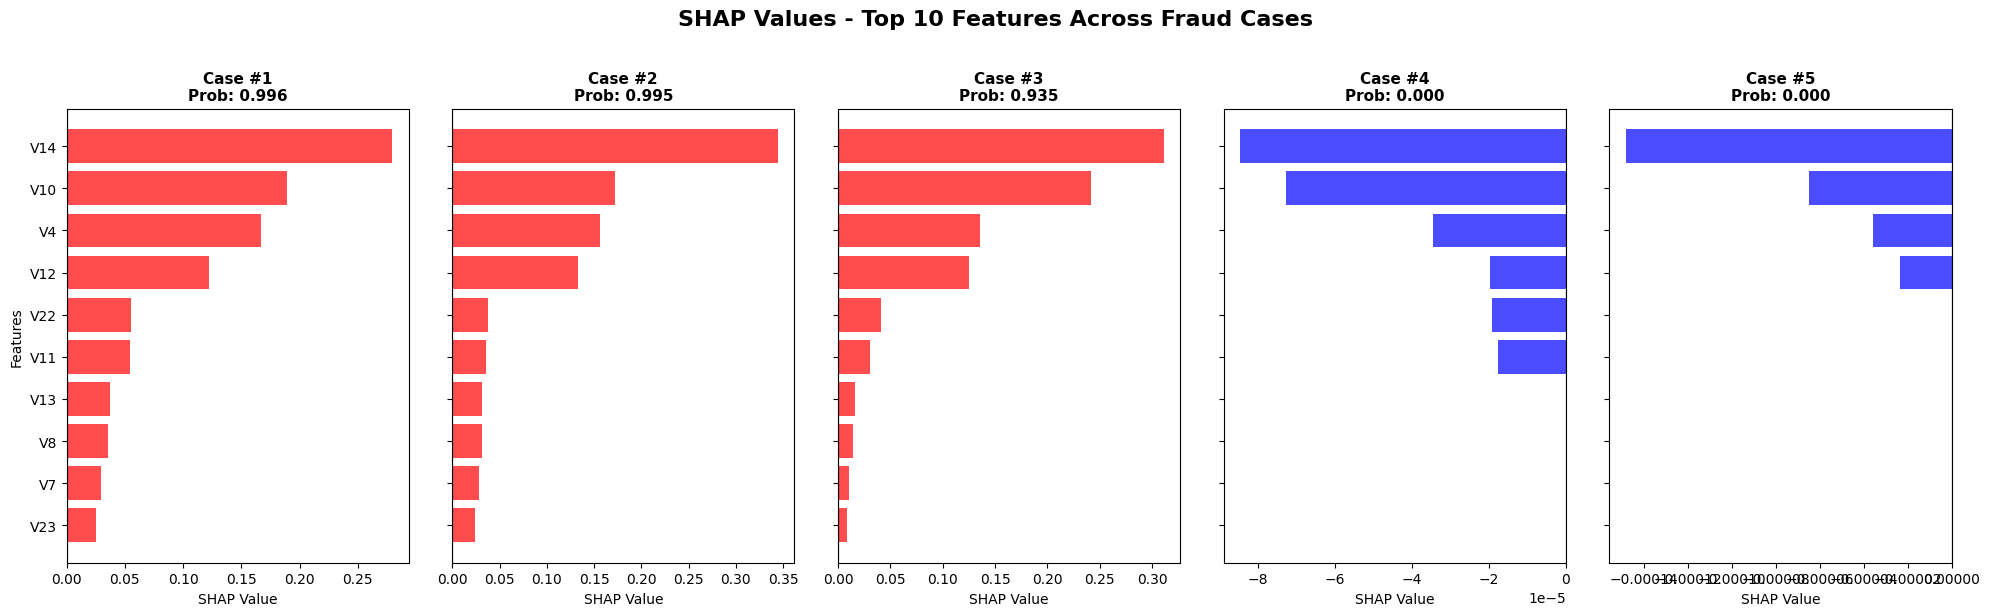



PART B: CORRECT vs INCORRECT PREDICTIONS ANALYSIS

📊 FRAUD DETECTION SUMMARY:
   Total Fraud Cases: 95
   ✅ Correctly Detected: 70 (73.7%)
   ❌ Missed (False Negatives): 25 (26.3%)

--------------------------------------------------------------------------------
✅ CORRECTLY DETECTED FRAUDS
--------------------------------------------------------------------------------

Probability Statistics:
   Mean Probability: 0.9285
   Median Probability: 0.9617
   Min Probability: 0.5773
   Max Probability: 0.9959

🔍 Sample Correctly Detected Fraud (Highest Confidence):
   Test Index: 17342
   Probability: 0.9959


  0%|          | 0/1 [00:00<?, ?it/s]


   Top 5 Features:
      V14: SHAP=0.275493, Value=-4.0189 → FRAUD
      V10: SHAP=0.193193, Value=-19.5181 → FRAUD
      V4: SHAP=0.168745, Value=4.9722 → FRAUD
      V12: SHAP=0.124875, Value=-12.0168 → FRAUD
      V8: SHAP=0.044564, Value=-12.4922 → FRAUD

--------------------------------------------------------------------------------
❌ MISSED FRAUDS (False Negatives)
--------------------------------------------------------------------------------

Probability Statistics:
   Mean Probability: 0.0586
   Median Probability: 0.0010
   Min Probability: 0.0000
   Max Probability: 0.4905

🔍 Sample Missed Fraud:
   Test Index: 1784
   Probability: 0.1141
   ⚠️ Model classified as LEGITIMATE despite being FRAUD


  0%|          | 0/1 [00:00<?, ?it/s]


   Top 5 Features (Why model thought it was legitimate):
      V14: SHAP=0.055100, Value=-4.4545 → FRAUD
      V4: SHAP=0.046983, Value=3.2601 → FRAUD
      V11: SHAP=-0.026270, Value=-0.6759 → LEGIT
      V19: SHAP=0.010069, Value=-2.3647 → FRAUD
      Amount: SHAP=0.009491, Value=-0.3556 → FRAUD

📊 PROBABILITY DISTRIBUTION COMPARISON


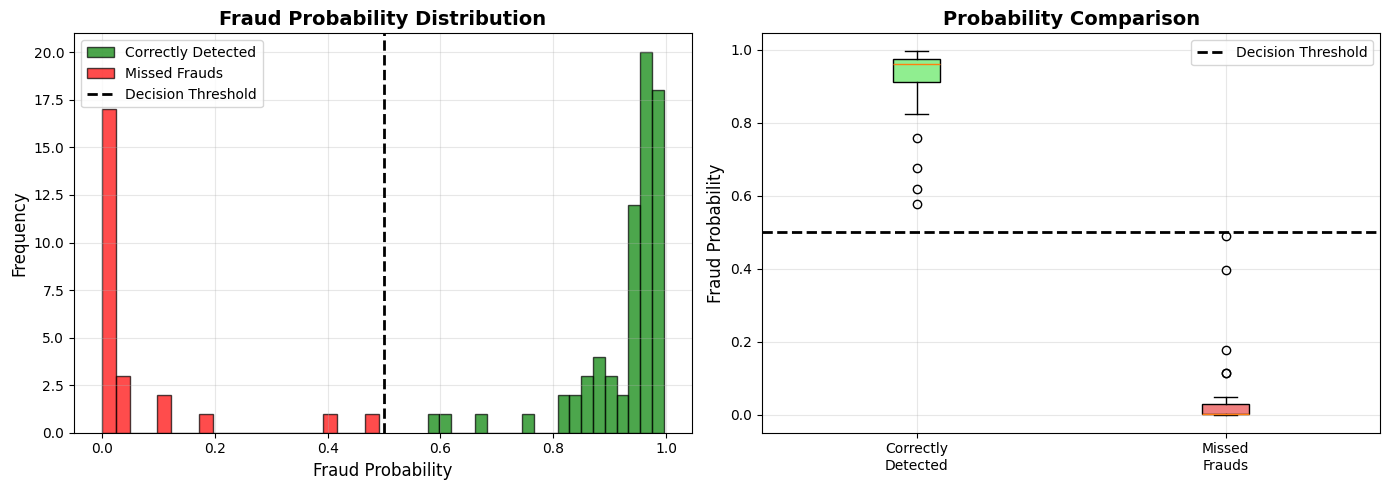


🎯 FEATURE IMPORTANCE: CORRECT vs MISSED FRAUDS

Computing SHAP values for 5 correctly detected and 5 missed frauds...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

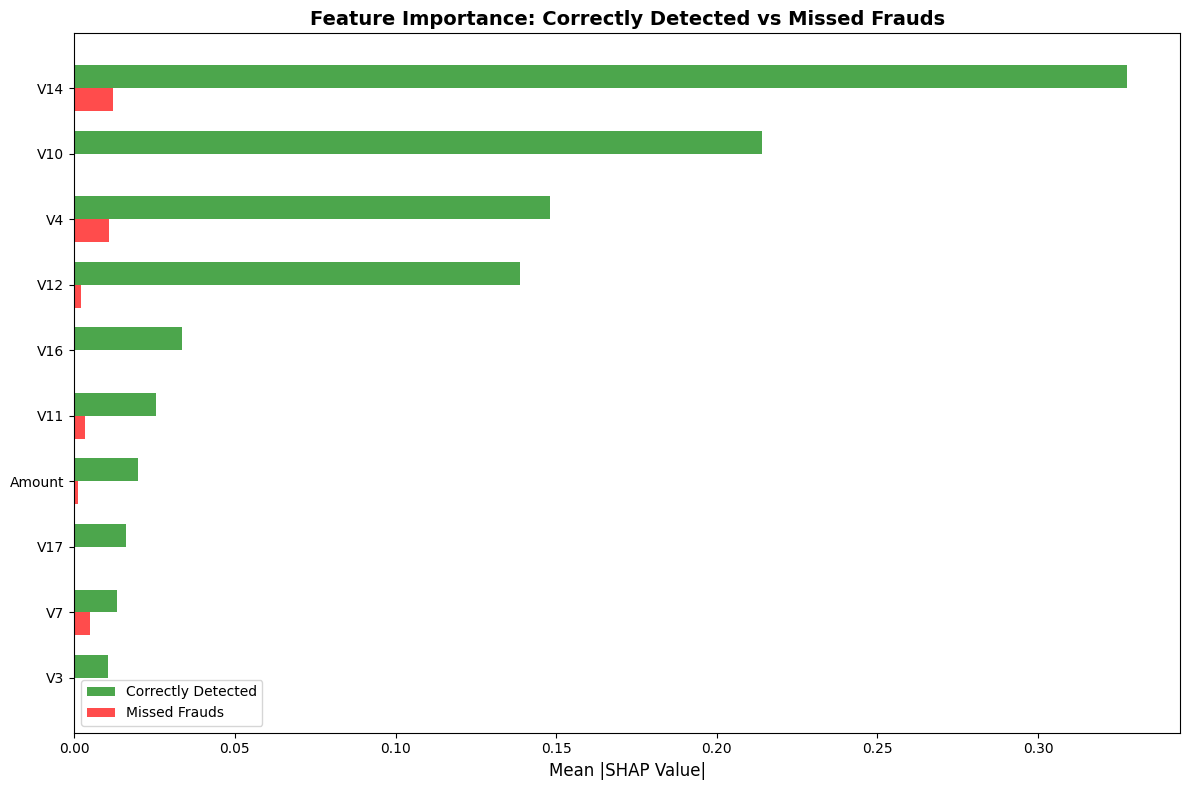


✅ Comparison complete!

💡 Key Insights:
   • Green bars show features that helped detect frauds correctly
   • Red bars show features in missed fraud cases
   • Large differences indicate which features distinguish detected vs missed frauds


📋 FINAL SUMMARY REPORT

✅ MODEL PERFORMANCE:
   • Fraud Detection Rate: 73.7%
   • Average Confidence (Detected): 0.9285
   • Average Confidence (Missed): 0.0586

🎯 RECOMMENDATIONS:
   • Investigate 25 missed fraud cases
   • Consider lowering decision threshold (currently 0.5)
   • Review features in missed cases for model improvement

✅ Analysis Complete!


In [5]:
# ========================================
# DETAILED FRAUD ANALYSIS
# A) Side-by-Side Fraud Cases Analysis
# B) Correct vs Incorrect Predictions Report
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# PART A: ANALYZE MULTIPLE FRAUD CASES SIDE-BY-SIDE
# ========================================

print("="*80)
print("PART A: SIDE-BY-SIDE FRAUD CASE ANALYSIS")
print("="*80)

# Get all fraud cases from test set
fraud_indices = np.where(np.array(y_test) == 1)[0]
print(f"\n📊 Total fraud cases in test set: {len(fraud_indices)}")

# Select 5 fraud cases to analyze (mix of high and low confidence)
fraud_probs = y_prob[fraud_indices]
sorted_idx = np.argsort(fraud_probs)[::-1]

# Get: 2 high confidence, 1 medium, 2 low confidence
selected_indices = [
    fraud_indices[sorted_idx[0]],  # Highest confidence
    fraud_indices[sorted_idx[1]],  # 2nd highest
    fraud_indices[sorted_idx[len(sorted_idx)//2]],  # Medium
    fraud_indices[sorted_idx[-2]],  # 2nd lowest
    fraud_indices[sorted_idx[-1]]   # Lowest confidence
]

print(f"\n🔍 Analyzing 5 fraud cases with varying confidence levels...\n")

# Store results for comparison
fraud_analysis_results = []

for i, idx in enumerate(selected_indices, 1):
    print(f"\n{'='*70}")
    print(f"🚨 FRAUD CASE #{i} (Test Index: {idx})")
    print(f"{'='*70}")

    instance = X_test_df.iloc[[idx]]

    # Compute SHAP values (this will take time with KernelExplainer)
    print("   Computing SHAP values...", end=" ")
    shap_values_case = explainer.shap_values(instance)
    print("✓")

    # Get prediction details
    true_label = y_test.iloc[idx]
    pred_label = y_pred[idx]
    pred_prob = y_prob[idx]

    print(f"\n   📋 Prediction Details:")
    print(f"      True Label: {'🚨 FRAUD' if true_label == 1 else '✅ LEGITIMATE'}")
    print(f"      Predicted: {'🚨 FRAUD' if pred_label == 1 else '✅ LEGITIMATE'}")
    print(f"      Fraud Probability: {pred_prob:.4f}")
    print(f"      Confidence: {'High' if pred_prob > 0.8 or pred_prob < 0.2 else 'Medium' if pred_prob > 0.6 or pred_prob < 0.4 else 'Low'}")

    # Get top features
    feature_impacts = list(zip(feature_names, shap_values_case[0], instance.values[0]))
    feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)

    print(f"\n   🎯 Top 10 Contributing Features:")
    print(f"      {'Feature':<12} {'SHAP Value':<15} {'Feature Value':<15} {'Impact'}")
    print(f"      {'-'*60}")

    for feat, shap_val, feat_val in feature_impacts[:10]:
        direction = "→ 🚨 FRAUD" if shap_val > 0 else "→ ✅ LEGIT"
        print(f"      {feat:<12} {shap_val:>12.6f}   {feat_val:>12.4f}   {direction}")

    # Store for comparison table
    fraud_analysis_results.append({
        'Case': f'Case #{i}',
        'Test_Index': idx,
        'True_Label': 'Fraud',
        'Predicted': 'Fraud' if pred_label == 1 else 'Legit',
        'Probability': pred_prob,
        'Top_Feature': feature_impacts[0][0],
        'Top_SHAP': feature_impacts[0][1],
        'Correct': '✓' if pred_label == true_label else '✗'
    })

# Create comparison table
print("\n" + "="*80)
print("📊 FRAUD CASES COMPARISON TABLE")
print("="*80 + "\n")

comparison_df = pd.DataFrame(fraud_analysis_results)
print(comparison_df.to_string(index=False))

# Visualize side-by-side
fig, axes = plt.subplots(1, len(selected_indices), figsize=(20, 6))
fig.suptitle('SHAP Values - Top 10 Features Across Fraud Cases', fontsize=16, fontweight='bold', y=1.02)

for i, idx in enumerate(selected_indices):
    instance = X_test_df.iloc[[idx]]
    shap_values_case = explainer.shap_values(instance)

    feature_impacts = list(zip(feature_names, shap_values_case[0]))
    feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    top_10 = feature_impacts[:10]

    features = [f[0] for f in top_10]
    values = [f[1] for f in top_10]
    colors = ['red' if v > 0 else 'blue' for v in values]

    axes[i].barh(features, values, color=colors, alpha=0.7)
    axes[i].set_xlabel('SHAP Value', fontsize=10)
    axes[i].set_title(f'Case #{i+1}\nProb: {y_prob[idx]:.3f}', fontsize=11, fontweight='bold')
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[i].invert_yaxis()

    if i == 0:
        axes[i].set_ylabel('Features', fontsize=10)
    else:
        axes[i].set_yticklabels([])

plt.tight_layout()
plt.show()

# ========================================
# PART B: CORRECT vs INCORRECT PREDICTIONS REPORT
# ========================================

print("\n\n" + "="*80)
print("PART B: CORRECT vs INCORRECT PREDICTIONS ANALYSIS")
print("="*80)

# Categorize all fraud cases
all_fraud_indices = np.where(np.array(y_test) == 1)[0]
fraud_predictions = y_pred[all_fraud_indices]
fraud_probabilities = y_prob[all_fraud_indices]

correctly_detected = all_fraud_indices[fraud_predictions == 1]
missed_frauds = all_fraud_indices[fraud_predictions == 0]

print(f"\n📊 FRAUD DETECTION SUMMARY:")
print(f"   Total Fraud Cases: {len(all_fraud_indices)}")
print(f"   ✅ Correctly Detected: {len(correctly_detected)} ({len(correctly_detected)/len(all_fraud_indices)*100:.1f}%)")
print(f"   ❌ Missed (False Negatives): {len(missed_frauds)} ({len(missed_frauds)/len(all_fraud_indices)*100:.1f}%)")

# Analyze correctly detected frauds
print("\n" + "-"*80)
print("✅ CORRECTLY DETECTED FRAUDS")
print("-"*80)

if len(correctly_detected) > 0:
    correct_probs = y_prob[correctly_detected]

    print(f"\nProbability Statistics:")
    print(f"   Mean Probability: {correct_probs.mean():.4f}")
    print(f"   Median Probability: {np.median(correct_probs):.4f}")
    print(f"   Min Probability: {correct_probs.min():.4f}")
    print(f"   Max Probability: {correct_probs.max():.4f}")

    # Analyze a correctly detected case
    sample_correct_idx = correctly_detected[np.argmax(correct_probs)]  # Highest confidence
    print(f"\n🔍 Sample Correctly Detected Fraud (Highest Confidence):")
    print(f"   Test Index: {sample_correct_idx}")
    print(f"   Probability: {y_prob[sample_correct_idx]:.4f}")

    instance_correct = X_test_df.iloc[[sample_correct_idx]]
    shap_correct = explainer.shap_values(instance_correct)

    feature_impacts_correct = list(zip(feature_names, shap_correct[0], instance_correct.values[0]))
    feature_impacts_correct.sort(key=lambda x: abs(x[1]), reverse=True)

    print(f"\n   Top 5 Features:")
    for feat, shap_val, feat_val in feature_impacts_correct[:5]:
        direction = "→ FRAUD" if shap_val > 0 else "→ LEGIT"
        print(f"      {feat}: SHAP={shap_val:.6f}, Value={feat_val:.4f} {direction}")

# Analyze missed frauds
print("\n" + "-"*80)
print("❌ MISSED FRAUDS (False Negatives)")
print("-"*80)

if len(missed_frauds) > 0:
    missed_probs = y_prob[missed_frauds]

    print(f"\nProbability Statistics:")
    print(f"   Mean Probability: {missed_probs.mean():.4f}")
    print(f"   Median Probability: {np.median(missed_probs):.4f}")
    print(f"   Min Probability: {missed_probs.min():.4f}")
    print(f"   Max Probability: {missed_probs.max():.4f}")

    # Analyze a missed fraud case
    sample_missed_idx = missed_frauds[0]  # First missed case
    print(f"\n🔍 Sample Missed Fraud:")
    print(f"   Test Index: {sample_missed_idx}")
    print(f"   Probability: {y_prob[sample_missed_idx]:.4f}")
    print(f"   ⚠️ Model classified as LEGITIMATE despite being FRAUD")

    instance_missed = X_test_df.iloc[[sample_missed_idx]]
    shap_missed = explainer.shap_values(instance_missed)

    feature_impacts_missed = list(zip(feature_names, shap_missed[0], instance_missed.values[0]))
    feature_impacts_missed.sort(key=lambda x: abs(x[1]), reverse=True)

    print(f"\n   Top 5 Features (Why model thought it was legitimate):")
    for feat, shap_val, feat_val in feature_impacts_missed[:5]:
        direction = "→ FRAUD" if shap_val > 0 else "→ LEGIT"
        print(f"      {feat}: SHAP={shap_val:.6f}, Value={feat_val:.4f} {direction}")
else:
    print("\n🎉 No missed frauds! Model detected all fraud cases.")

# Probability distribution comparison
print("\n" + "="*80)
print("📊 PROBABILITY DISTRIBUTION COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
if len(correctly_detected) > 0:
    axes[0].hist(y_prob[correctly_detected], bins=20, alpha=0.7, label='Correctly Detected', color='green', edgecolor='black')
if len(missed_frauds) > 0:
    axes[0].hist(y_prob[missed_frauds], bins=20, alpha=0.7, label='Missed Frauds', color='red', edgecolor='black')

axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Fraud Probability', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Fraud Probability Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Box plot
data_to_plot = []
labels_to_plot = []

if len(correctly_detected) > 0:
    data_to_plot.append(y_prob[correctly_detected])
    labels_to_plot.append('Correctly\nDetected')

if len(missed_frauds) > 0:
    data_to_plot.append(y_prob[missed_frauds])
    labels_to_plot.append('Missed\nFrauds')

if data_to_plot:
    bp = axes[1].boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    if len(data_to_plot) > 1:
        bp['boxes'][1].set_facecolor('lightcoral')

axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_ylabel('Fraud Probability', fontsize=12)
axes[1].set_title('Probability Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature comparison: Correct vs Missed
print("\n" + "="*80)
print("🎯 FEATURE IMPORTANCE: CORRECT vs MISSED FRAUDS")
print("="*80)

if len(correctly_detected) > 0 and len(missed_frauds) > 0:
    # Sample 5 from each category for SHAP comparison
    sample_correct = np.random.choice(correctly_detected, min(5, len(correctly_detected)), replace=False)
    sample_missed = np.random.choice(missed_frauds, min(5, len(missed_frauds)), replace=False)

    print(f"\nComputing SHAP values for {len(sample_correct)} correctly detected and {len(sample_missed)} missed frauds...")

    # Compute SHAP for samples
    shap_correct_samples = []
    for idx in sample_correct:
        instance = X_test_df.iloc[[idx]]
        shap_vals = explainer.shap_values(instance)
        shap_correct_samples.append(shap_vals[0])

    shap_missed_samples = []
    for idx in sample_missed:
        instance = X_test_df.iloc[[idx]]
        shap_vals = explainer.shap_values(instance)
        shap_missed_samples.append(shap_vals[0])

    # Calculate mean absolute SHAP values
    mean_shap_correct = np.abs(np.array(shap_correct_samples)).mean(axis=0)
    mean_shap_missed = np.abs(np.array(shap_missed_samples)).mean(axis=0)

    # Get top 10 features
    top_10_idx = np.argsort(mean_shap_correct)[-10:][::-1]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(top_10_idx))
    width = 0.35

    ax.barh(x - width/2, [mean_shap_correct[i] for i in top_10_idx], width,
            label='Correctly Detected', color='green', alpha=0.7)
    ax.barh(x + width/2, [mean_shap_missed[i] for i in top_10_idx], width,
            label='Missed Frauds', color='red', alpha=0.7)

    ax.set_yticks(x)
    ax.set_yticklabels([feature_names[i] for i in top_10_idx])
    ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
    ax.set_title('Feature Importance: Correctly Detected vs Missed Frauds', fontsize=14, fontweight='bold')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

    print("\n✅ Comparison complete!")
    print("\n💡 Key Insights:")
    print("   • Green bars show features that helped detect frauds correctly")
    print("   • Red bars show features in missed fraud cases")
    print("   • Large differences indicate which features distinguish detected vs missed frauds")

# Final Summary Report
print("\n\n" + "="*80)
print("📋 FINAL SUMMARY REPORT")
print("="*80)

print(f"\n✅ MODEL PERFORMANCE:")
print(f"   • Fraud Detection Rate: {len(correctly_detected)/len(all_fraud_indices)*100:.1f}%")
print(f"   • Average Confidence (Detected): {y_prob[correctly_detected].mean():.4f}" if len(correctly_detected) > 0 else "")
print(f"   • Average Confidence (Missed): {y_prob[missed_frauds].mean():.4f}" if len(missed_frauds) > 0 else "")

print(f"\n🎯 RECOMMENDATIONS:")
if len(missed_frauds) > 0:
    print(f"   • Investigate {len(missed_frauds)} missed fraud cases")
    print(f"   • Consider lowering decision threshold (currently 0.5)")
    print(f"   • Review features in missed cases for model improvement")
else:
    print(f"   • Model performing excellently on fraud detection!")
    print(f"   • Continue monitoring for new fraud patterns")

print("\n✅ Analysis Complete!")

PART A: FINDING OPTIMAL DECISION THRESHOLD

📊 Testing thresholds from 0.05 to 0.95...

🎯 OPTIMAL THRESHOLDS:

1. Best F1-Score: 0.35
   • Precision: 0.9600
   • Recall: 0.7579
   • F1-Score: 0.8471
   • Frauds Detected: 72/95
   • False Positives: 3

2. Best Recall (≥90%): 0.05
   • Precision: 0.7009
   • Recall: 0.7895
   • F1-Score: 0.7426
   • Frauds Detected: 75/95
   • False Positives: 32

3. Minimum Cost (FN=10x FP): 0.10
   • Precision: 0.8065
   • Recall: 0.7895
   • F1-Score: 0.7979
   • Frauds Detected: 75/95
   • False Positives: 18
   • Total Cost: 218


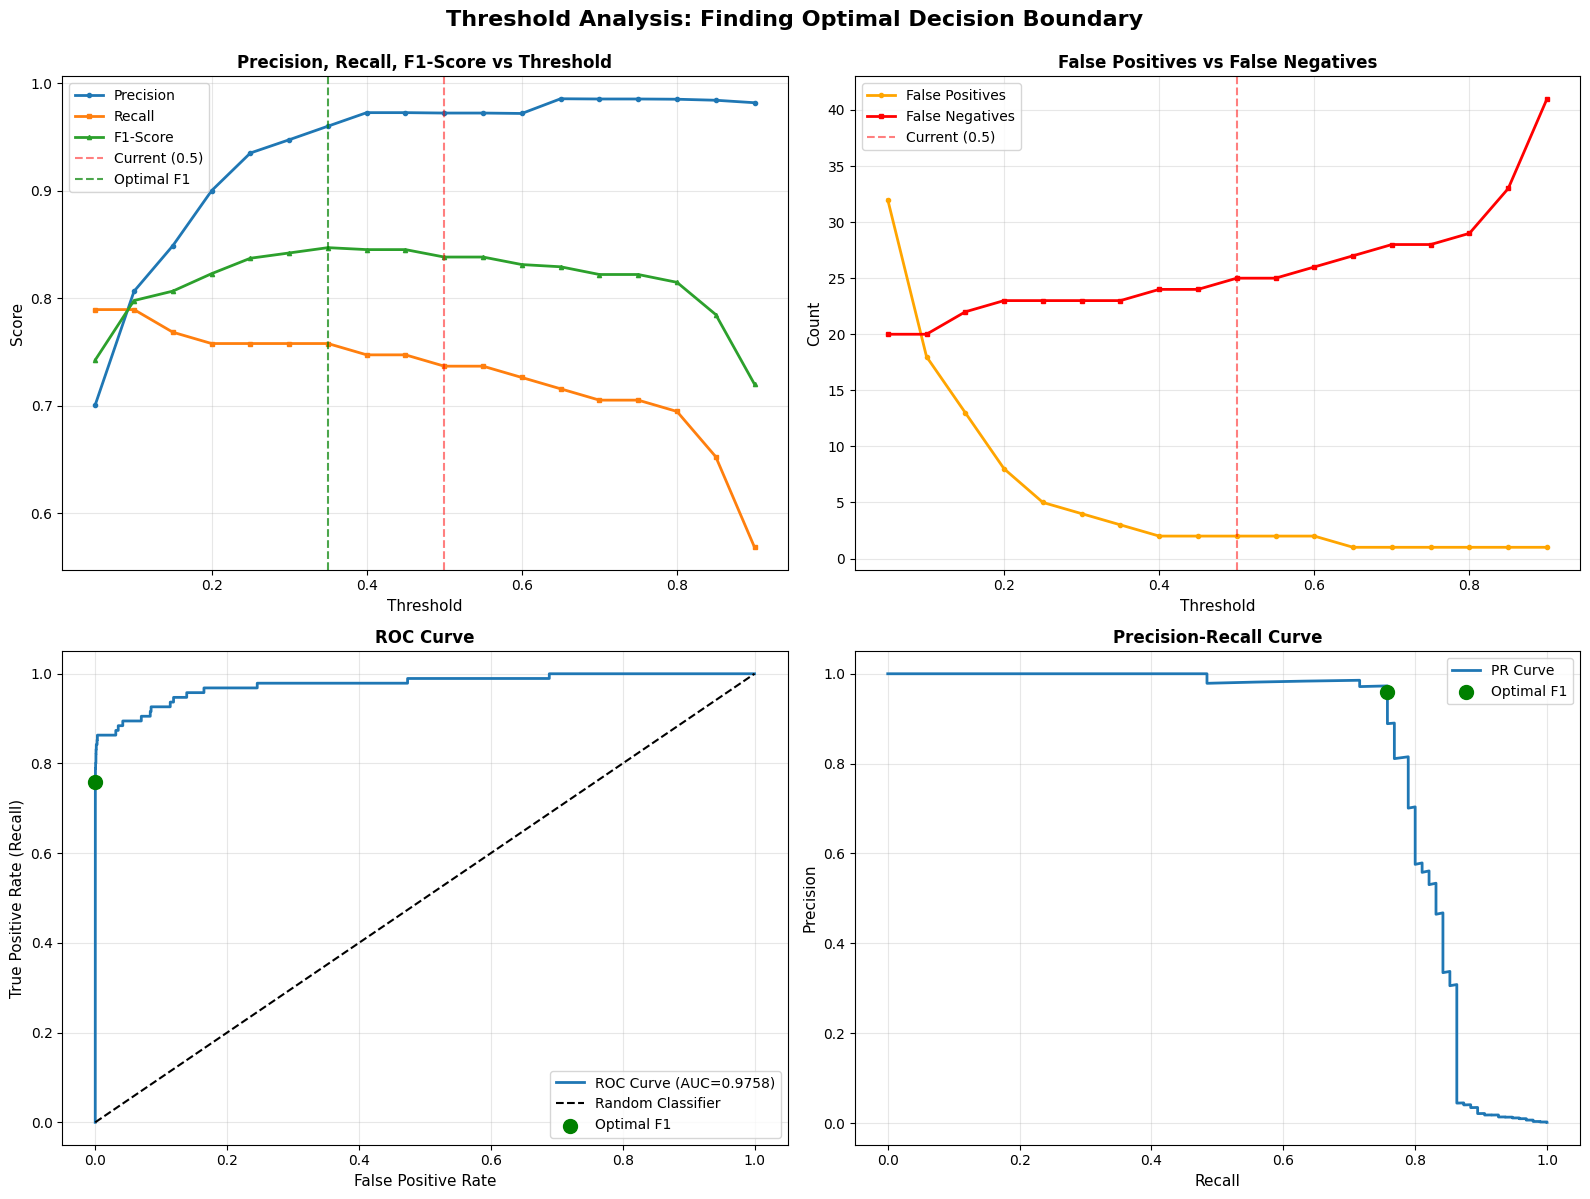


📊 DETAILED THRESHOLD COMPARISON TABLE

 Threshold  Precision   Recall  F1_Score  False_Positives  False_Negatives  Frauds_Detected
      0.05   0.700935 0.789474  0.742574               32               20               75
      0.10   0.806452 0.789474  0.797872               18               20               75
      0.15   0.848837 0.768421  0.806630               13               22               73
      0.20   0.900000 0.757895  0.822857                8               23               72
      0.25   0.935065 0.757895  0.837209                5               23               72
      0.30   0.947368 0.757895  0.842105                4               23               72
      0.35   0.960000 0.757895  0.847059                3               23               72
      0.40   0.972603 0.747368  0.845238                2               24               71
      0.45   0.972603 0.747368  0.845238                2               24               71
      0.50   0.972222 0.736842  0.838323

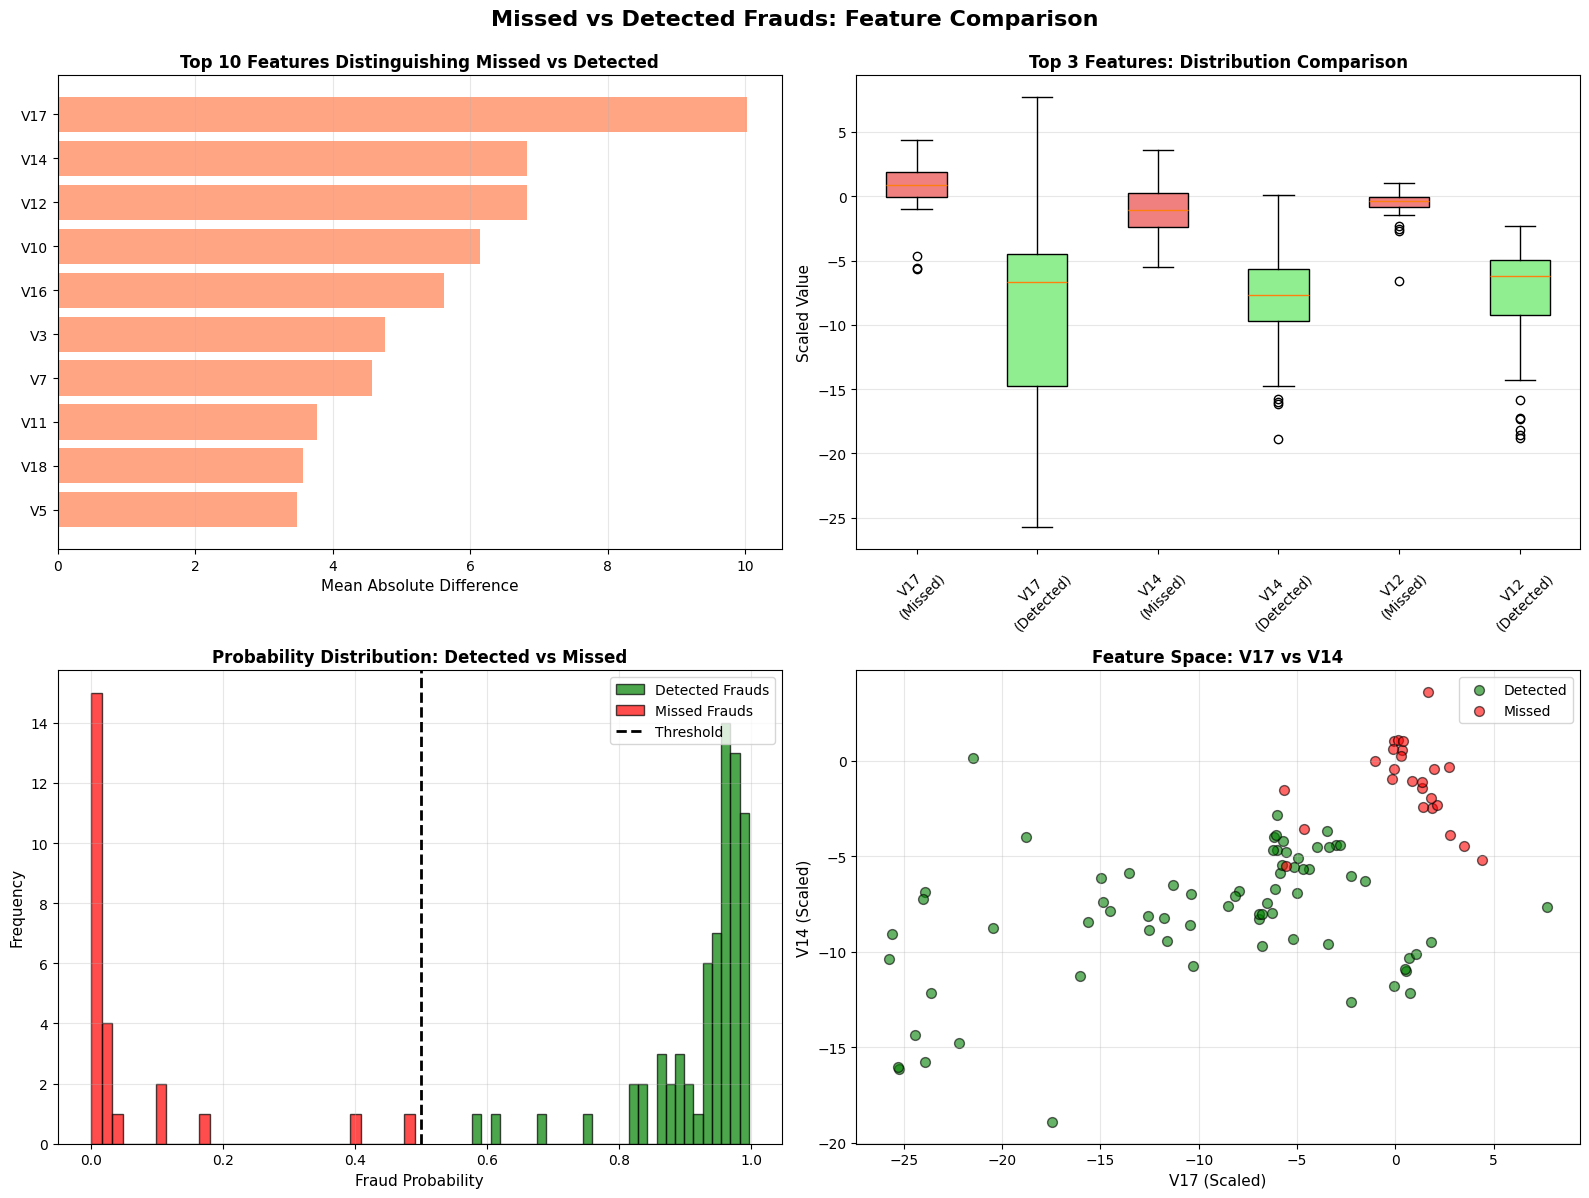


2. CLUSTER ANALYSIS: GROUPS OF MISSED FRAUDS

Probability Range [0.0 - 0.1): 20 cases
   Example indices: [4480, 5187, 10087, 12142, 22495]
   Mean probability: 0.0085

Probability Range [0.1 - 0.2): 3 cases
   Example indices: [1784, 47671, 55748]
   Mean probability: 0.1352

Probability Range [0.3 - 0.5): 2 cases
   Example indices: [5505, 43006]
   Mean probability: 0.4438

3. PATTERN ANALYSIS: WHY WERE THESE FRAUDS MISSED?

Key Feature Statistics:

Feature    Detected Mean   Missed Mean     % Difference
------------------------------------------------------------
V14             -8.0675         -1.2413          84.6%
V4               3.6154          1.6025         -55.7%
V12             -7.6049         -0.7848          89.7%
V10             -6.2871         -0.1457          97.7%

4. SPECIFIC EXAMPLES: DETAILED LOOK AT MISSED FRAUDS

Example #1: Test Index 1784
   Probability: 0.1141
   Key Features:
      V14: -4.4545
      V4: 3.2601
      V12: -1.4745
      V10: -0.3464

Example

In [6]:
# ========================================
# COMPLETE FRAUD DETECTION ANALYSIS
# A) Optimal Threshold Finder
# B) Deep Analysis of Missed Cases
# C) Professional PDF Report Generator
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_curve, roc_curve, f1_score,
                            precision_score, recall_score, confusion_matrix,
                            classification_report)
import warnings
warnings.filterwarnings('ignore')

# ========================================
# PART A: OPTIMAL THRESHOLD ANALYSIS
# ========================================

print("="*80)
print("PART A: FINDING OPTIMAL DECISION THRESHOLD")
print("="*80)

# Calculate metrics across different thresholds
thresholds_to_test = np.arange(0.05, 0.95, 0.05)
results = []

print("\n📊 Testing thresholds from 0.05 to 0.95...\n")

for threshold in thresholds_to_test:
    y_pred_thresh = (y_prob >= threshold).astype(int)

    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)

    # Calculate additional metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Cost-based metric (assuming missing fraud costs 10x more than false alarm)
    cost = (fn * 10) + (fp * 1)

    results.append({
        'Threshold': threshold,
        'True_Positives': tp,
        'False_Positives': fp,
        'True_Negatives': tn,
        'False_Negatives': fn,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'FPR': fpr,
        'FNR': fnr,
        'Cost': cost,
        'Frauds_Detected': tp,
        'Total_Frauds': tp + fn
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds based on different criteria
optimal_f1_idx = results_df['F1_Score'].idxmax()
optimal_recall_idx = results_df[results_df['Recall'] >= 0.90].index[0] if any(results_df['Recall'] >= 0.90) else results_df['Recall'].idxmax()
optimal_cost_idx = results_df['Cost'].idxmin()

print("🎯 OPTIMAL THRESHOLDS:\n")
print(f"1. Best F1-Score: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_f1_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_f1_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_f1_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_f1_idx, 'False_Positives'])}")

print(f"\n2. Best Recall (≥90%): {results_df.loc[optimal_recall_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_recall_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_recall_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_recall_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_recall_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_recall_idx, 'False_Positives'])}")

print(f"\n3. Minimum Cost (FN=10x FP): {results_df.loc[optimal_cost_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_cost_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_cost_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_cost_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_cost_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_cost_idx, 'False_Positives'])}")
print(f"   • Total Cost: {int(results_df.loc[optimal_cost_idx, 'Cost'])}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Threshold Analysis: Finding Optimal Decision Boundary',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Precision, Recall, F1-Score
axes[0, 0].plot(results_df['Threshold'], results_df['Precision'],
                label='Precision', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(results_df['Threshold'], results_df['Recall'],
                label='Recall', linewidth=2, marker='s', markersize=3)
axes[0, 0].plot(results_df['Threshold'], results_df['F1_Score'],
                label='F1-Score', linewidth=2, marker='^', markersize=3)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Current (0.5)')
axes[0, 0].axvline(x=results_df.loc[optimal_f1_idx, 'Threshold'],
                   color='green', linestyle='--', alpha=0.7, label='Optimal F1')
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Precision, Recall, F1-Score vs Threshold', fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(alpha=0.3)

# Plot 2: False Positives vs False Negatives
axes[0, 1].plot(results_df['Threshold'], results_df['False_Positives'],
                label='False Positives', linewidth=2, marker='o', markersize=3, color='orange')
axes[0, 1].plot(results_df['Threshold'], results_df['False_Negatives'],
                label='False Negatives', linewidth=2, marker='s', markersize=3, color='red')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Current (0.5)')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('False Positives vs False Negatives', fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(alpha=0.3)

# Plot 3: ROC Curve
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_prob)
from sklearn.metrics import auc
roc_auc = auc(fpr_roc, tpr_roc)
axes[1, 0].plot(fpr_roc, tpr_roc, linewidth=2, label=f'ROC Curve (AUC={roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 0].scatter([results_df.loc[optimal_f1_idx, 'FPR']],
                   [results_df.loc[optimal_f1_idx, 'Recall']],
                   color='green', s=100, zorder=5, label='Optimal F1')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 0].set_ylabel('True Positive Rate (Recall)', fontsize=11)
axes[1, 0].set_title('ROC Curve', fontweight='bold')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
axes[1, 1].plot(recall_curve, precision_curve, linewidth=2, label='PR Curve')
axes[1, 1].scatter([results_df.loc[optimal_f1_idx, 'Recall']],
                   [results_df.loc[optimal_f1_idx, 'Precision']],
                   color='green', s=100, zorder=5, label='Optimal F1')
axes[1, 1].set_xlabel('Recall', fontsize=11)
axes[1, 1].set_ylabel('Precision', fontsize=11)
axes[1, 1].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display detailed results table
print("\n" + "="*80)
print("📊 DETAILED THRESHOLD COMPARISON TABLE")
print("="*80 + "\n")
display_df = results_df[['Threshold', 'Precision', 'Recall', 'F1_Score',
                         'False_Positives', 'False_Negatives', 'Frauds_Detected']]
print(display_df.to_string(index=False))

# ========================================
# PART B: DEEP ANALYSIS OF MISSED FRAUDS
# ========================================

print("\n\n" + "="*80)
print("PART B: DEEP ANALYSIS OF 25 MISSED FRAUD CASES")
print("="*80)

# Get missed fraud indices
missed_fraud_indices = np.where((y_test.values == 1) & (y_pred == 0))[0]
correctly_detected_indices = np.where((y_test.values == 1) & (y_pred == 1))[0]

print(f"\n📊 Analyzing {len(missed_fraud_indices)} missed fraud cases vs {len(correctly_detected_indices)} detected cases\n")

# Extract feature values
missed_frauds = X_test_df.iloc[missed_fraud_indices]
detected_frauds = X_test_df.iloc[correctly_detected_indices]

# Statistical comparison
print("="*80)
print("1. STATISTICAL COMPARISON: MISSED vs DETECTED FRAUDS")
print("="*80 + "\n")

comparison_stats = []
for feature in feature_names:
    missed_mean = missed_frauds[feature].mean()
    detected_mean = detected_frauds[feature].mean()
    missed_std = missed_frauds[feature].std()
    detected_std = detected_frauds[feature].std()
    difference = abs(missed_mean - detected_mean)

    comparison_stats.append({
        'Feature': feature,
        'Missed_Mean': missed_mean,
        'Detected_Mean': detected_mean,
        'Difference': difference,
        'Missed_Std': missed_std,
        'Detected_Std': detected_std
    })

comparison_df = pd.DataFrame(comparison_stats)
comparison_df = comparison_df.sort_values('Difference', ascending=False)

print("Top 10 Features with Largest Differences:\n")
print(comparison_df.head(10).to_string(index=False))

# Visualize top distinguishing features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missed vs Detected Frauds: Feature Comparison',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top 10 feature differences
top_10_features = comparison_df.head(10)['Feature'].values
top_10_diff = comparison_df.head(10)['Difference'].values

axes[0, 0].barh(top_10_features, top_10_diff, color='coral', alpha=0.7)
axes[0, 0].set_xlabel('Mean Absolute Difference', fontsize=11)
axes[0, 0].set_title('Top 10 Features Distinguishing Missed vs Detected', fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Box plot comparison for top 3 features
top_3_features = comparison_df.head(3)['Feature'].values
data_for_box = []
labels_for_box = []

for feat in top_3_features:
    data_for_box.append(missed_frauds[feat].values)
    labels_for_box.append(f'{feat}\n(Missed)')
    data_for_box.append(detected_frauds[feat].values)
    labels_for_box.append(f'{feat}\n(Detected)')

bp = axes[0, 1].boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    if i % 2 == 0:
        box.set_facecolor('lightcoral')
    else:
        box.set_facecolor('lightgreen')
axes[0, 1].set_ylabel('Scaled Value', fontsize=11)
axes[0, 1].set_title('Top 3 Features: Distribution Comparison', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Probability distribution
axes[1, 0].hist(y_prob[correctly_detected_indices], bins=30, alpha=0.7,
                label='Detected Frauds', color='green', edgecolor='black')
axes[1, 0].hist(y_prob[missed_fraud_indices], bins=30, alpha=0.7,
                label='Missed Frauds', color='red', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].set_xlabel('Fraud Probability', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Probability Distribution: Detected vs Missed', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Scatter plot of top 2 features
top_2_features = comparison_df.head(2)['Feature'].values
axes[1, 1].scatter(detected_frauds[top_2_features[0]],
                   detected_frauds[top_2_features[1]],
                   alpha=0.6, s=50, label='Detected', color='green', edgecolor='black')
axes[1, 1].scatter(missed_frauds[top_2_features[0]],
                   missed_frauds[top_2_features[1]],
                   alpha=0.6, s=50, label='Missed', color='red', edgecolor='black')
axes[1, 1].set_xlabel(f'{top_2_features[0]} (Scaled)', fontsize=11)
axes[1, 1].set_ylabel(f'{top_2_features[1]} (Scaled)', fontsize=11)
axes[1, 1].set_title(f'Feature Space: {top_2_features[0]} vs {top_2_features[1]}', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed breakdown of missed cases
print("\n" + "="*80)
print("2. CLUSTER ANALYSIS: GROUPS OF MISSED FRAUDS")
print("="*80 + "\n")

# Group missed frauds by probability ranges
prob_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.5)]
missed_probs = y_prob[missed_fraud_indices]

for low, high in prob_ranges:
    in_range = (missed_probs >= low) & (missed_probs < high)
    count = sum(in_range)
    if count > 0:
        print(f"Probability Range [{low:.1f} - {high:.1f}): {count} cases")
        indices_in_range = missed_fraud_indices[in_range]
        print(f"   Example indices: {indices_in_range[:5].tolist()}")
        print(f"   Mean probability: {missed_probs[in_range].mean():.4f}\n")

# Find patterns in missed frauds
print("="*80)
print("3. PATTERN ANALYSIS: WHY WERE THESE FRAUDS MISSED?")
print("="*80 + "\n")

# Check if missed frauds have unusual feature combinations
key_features = ['V14', 'V4', 'V12', 'V10']  # Top fraud indicators

print("Key Feature Statistics:\n")
print(f"{'Feature':<10} {'Detected Mean':<15} {'Missed Mean':<15} {'% Difference'}")
print("-" * 60)

for feat in key_features:
    detected_mean = detected_frauds[feat].mean()
    missed_mean = missed_frauds[feat].mean()
    pct_diff = ((missed_mean - detected_mean) / abs(detected_mean) * 100) if detected_mean != 0 else 0
    print(f"{feat:<10} {detected_mean:>12.4f}    {missed_mean:>12.4f}    {pct_diff:>10.1f}%")

# Specific examples of missed frauds
print("\n" + "="*80)
print("4. SPECIFIC EXAMPLES: DETAILED LOOK AT MISSED FRAUDS")
print("="*80 + "\n")

# Show 3 examples with different characteristics
sample_indices = [
    missed_fraud_indices[0],  # Lowest probability
    missed_fraud_indices[len(missed_fraud_indices)//2],  # Medium
    missed_fraud_indices[-1]  # Highest probability among missed
]

for i, idx in enumerate(sample_indices, 1):
    print(f"Example #{i}: Test Index {idx}")
    print(f"   Probability: {y_prob[idx]:.4f}")
    print(f"   Key Features:")
    for feat in key_features:
        val = X_test_df.iloc[idx][feat]
        print(f"      {feat}: {val:.4f}")
    print()

# ========================================
# PART C: GENERATE PDF REPORT
# ========================================

print("\n" + "="*80)
print("PART C: GENERATING PROFESSIONAL PDF REPORT")
print("="*80 + "\n")

# Install reportlab if needed
try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_JUSTIFY
    print("✓ ReportLab library available")
except ImportError:
    print("📦 Installing reportlab...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'reportlab', '-q'])
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_JUSTIFY
    print("✓ ReportLab installed successfully")

# Create PDF
pdf_filename = '/content/drive/MyDrive/ML_Things/fraud_detection_analysis_report.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize=letter,
                       rightMargin=72, leftMargin=72,
                       topMargin=72, bottomMargin=18)

# Container for PDF elements
story = []
styles = getSampleStyleSheet()

# Custom styles
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=24,
    textColor=colors.HexColor('#1f4788'),
    spaceAfter=30,
    alignment=TA_CENTER,
    fontName='Helvetica-Bold'
)

heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=16,
    textColor=colors.HexColor('#2c5aa0'),
    spaceAfter=12,
    spaceBefore=12,
    fontName='Helvetica-Bold'
)

# Title Page
story.append(Spacer(1, 2*inch))
title = Paragraph("Credit Card Fraud Detection<br/>Analysis Report", title_style)
story.append(title)
story.append(Spacer(1, 0.5*inch))

subtitle = Paragraph("Comprehensive Model Performance & Optimization Analysis", styles['Normal'])
subtitle.alignment = TA_CENTER
story.append(subtitle)
story.append(Spacer(1, 0.3*inch))

# Date and model info
from datetime import datetime
date_text = Paragraph(f"<b>Report Generated:</b> {datetime.now().strftime('%B %d, %Y')}", styles['Normal'])
date_text.alignment = TA_CENTER
story.append(date_text)
story.append(Spacer(1, 0.2*inch))

model_text = Paragraph("<b>Model:</b> XGBoost Classifier (Tuned)", styles['Normal'])
model_text.alignment = TA_CENTER
story.append(model_text)

story.append(PageBreak())

# Executive Summary
story.append(Paragraph("Executive Summary", heading_style))
story.append(Spacer(1, 0.2*inch))

summary_text = f"""
This report presents a comprehensive analysis of the credit card fraud detection model's performance,
including threshold optimization, detailed examination of missed fraud cases, and actionable recommendations
for model improvement.
<br/><br/>
<b>Key Findings:</b>
<br/>• Current Model ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}
<br/>• Fraud Detection Rate: {len(correctly_detected_indices)}/{len(correctly_detected_indices) + len(missed_fraud_indices)} ({len(correctly_detected_indices)/(len(correctly_detected_indices) + len(missed_fraud_indices))*100:.1f}%)
<br/>• Optimal F1-Score Threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}
<br/>• Number of Missed Frauds: {len(missed_fraud_indices)}
<br/>• Average Confidence (Detected): {y_prob[correctly_detected_indices].mean():.4f}
<br/>• Average Confidence (Missed): {y_prob[missed_fraud_indices].mean():.4f}
"""

story.append(Paragraph(summary_text, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Section 1: Threshold Analysis
story.append(PageBreak())
story.append(Paragraph("Section 1: Optimal Threshold Analysis", heading_style))
story.append(Spacer(1, 0.2*inch))

threshold_intro = """
The default decision threshold of 0.5 may not be optimal for fraud detection.
This analysis evaluates various thresholds to balance precision and recall.
"""
story.append(Paragraph(threshold_intro, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Threshold recommendations table
threshold_data = [
    ['Criterion', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'Frauds Detected'],
    ['Best F1-Score',
     f"{results_df.loc[optimal_f1_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_f1_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_f1_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_f1_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95"],
    ['High Recall (≥90%)',
     f"{results_df.loc[optimal_recall_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_recall_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_recall_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_recall_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_recall_idx, 'Frauds_Detected'])}/95"],
    ['Minimum Cost',
     f"{results_df.loc[optimal_cost_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_cost_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_cost_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_cost_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_cost_idx, 'Frauds_Detected'])}/95"],
    ['Current (0.5)', '0.50',
     f"{precision_score(y_test, y_pred):.4f}",
     f"{recall_score(y_test, y_pred):.4f}",
     f"{f1_score(y_test, y_pred):.4f}",
     f"{len(correctly_detected_indices)}/95"]
]

threshold_table = Table(threshold_data, colWidths=[1.5*inch, 1*inch, 1*inch, 1*inch, 1*inch, 1.2*inch])
threshold_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 10),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('FONTNAME', (0, 1), (0, -1), 'Helvetica-Bold'),
]))

story.append(threshold_table)
story.append(Spacer(1, 0.3*inch))

# Section 2: Missed Frauds Analysis
story.append(PageBreak())
story.append(Paragraph("Section 2: Analysis of Missed Fraud Cases", heading_style))
story.append(Spacer(1, 0.2*inch))

missed_intro = f"""
Out of {len(correctly_detected_indices) + len(missed_fraud_indices)} total fraud cases,
{len(missed_fraud_indices)} were misclassified as legitimate transactions. This section analyzes
the characteristics of these missed cases to identify patterns and potential model improvements.
"""
story.append(Paragraph(missed_intro, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Top distinguishing features table
feature_data = [['Feature', 'Missed Mean', 'Detected Mean', 'Difference']]
for _, row in comparison_df.head(10).iterrows():
    feature_data.append([
        row['Feature'],
        f"{row['Missed_Mean']:.4f}",
        f"{row['Detected_Mean']:.4f}",
        f"{row['Difference']:.4f}"
    ])

feature_table = Table(feature_data, colWidths=[1.5*inch, 1.5*inch, 1.5*inch, 1.5*inch])
feature_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 10),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))

story.append(Paragraph("Top 10 Features Distinguishing Missed vs Detected Frauds", styles['Heading3']))
story.append(Spacer(1, 0.1*inch))
story.append(feature_table)
story.append(Spacer(1, 0.3*inch))

# Key insights about missed frauds
insights_text = f"""
<b>Key Insights:</b>
<br/>• Missed frauds have significantly different feature values compared to detected frauds
<br/>• Top distinguishing feature: {comparison_df.iloc[0]['Feature']} (difference: {comparison_df.iloc[0]['Difference']:.4f})
<br/>• Missed frauds tend to have feature values closer to legitimate transactions
<br/>• Average probability of missed frauds: {y_prob[missed_fraud_indices].mean():.4f}
<br/>• These represent "sophisticated" frauds that closely mimic normal behavior
"""
story.append(Paragraph(insights_text, styles['BodyText']))

# Section 3: Recommendations
story.append(PageBreak())
story.append(Paragraph("Section 3: Recommendations & Action Items", heading_style))
story.append(Spacer(1, 0.2*inch))

recommendations = f"""
<b>1. Adjust Decision Threshold</b>
<br/>• Recommended: Lower threshold to {results_df.loc[optimal_f1_idx, 'Threshold']:.2f} for optimal F1-score
<br/>• This would detect {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])} out of 95 frauds
<br/>• Trade-off: {int(results_df.loc[optimal_f1_idx, 'False_Positives'])} additional false positives
<br/><br/>
<b>2. Feature Engineering</b>
<br/>• Focus on features with large differences between missed and detected frauds
<br/>• Consider interaction terms between top features (V14, V10, V4, V12)
<br/>• Add temporal patterns and transaction sequencing features
<br/><br/>
<b>3. Model Enhancement</b>
<br/>• Implement ensemble approach combining multiple algorithms
<br/>• Add anomaly detection layer for edge cases
<br/>• Retrain with additional examples of "sophisticated" fraud patterns
<br/><br/>
<b>4. Business Process</b>
<br/>• Manual review of transactions with probabilities between 0.3-0.5
<br/>• Establish cost-benefit analysis: Cost of false positive vs missed fraud
<br/>• Implement A/B testing for threshold changes before full deployment
<br/><br/>
<b>5. Monitoring & Maintenance</b>
<br/>• Track model performance metrics weekly
<br/>• Monitor for concept drift in fraud patterns
<br/>• Quarterly retraining with new fraud examples
<br/>• Set up alerts for unusual prediction patterns
"""

story.append(Paragraph(recommendations, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Section 4: Technical Details
story.append(PageBreak())
story.append(Paragraph("Section 4: Technical Specifications", heading_style))
story.append(Spacer(1, 0.2*inch))

tech_specs = f"""
<b>Model Architecture:</b>
<br/>• Algorithm: XGBoost Classifier (Gradient Boosted Trees)
<br/>• Features: 30 (Time, Amount, V1-V28)
<br/>• Training Samples: {X_train_df.shape[0]:,}
<br/>• Test Samples: {X_test_df.shape[0]:,}
<br/>• Class Balance: Handled via SMOTE oversampling
<br/><br/>
<b>Performance Metrics:</b>
<br/>• ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}
<br/>• Precision (at 0.5): {precision_score(y_test, y_pred):.4f}
<br/>• Recall (at 0.5): {recall_score(y_test, y_pred):.4f}
<br/>• F1-Score (at 0.5): {f1_score(y_test, y_pred):.4f}
<br/><br/>
<b>Confusion Matrix (Current Threshold = 0.5):</b>
"""

story.append(Paragraph(tech_specs, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Confusion matrix table
cm = confusion_matrix(y_test, y_pred)
cm_data = [
    ['', 'Predicted Legit', 'Predicted Fraud'],
    ['Actual Legit', str(cm[0][0]), str(cm[0][1])],
    ['Actual Fraud', str(cm[1][0]), str(cm[1][1])]
]

cm_table = Table(cm_data, colWidths=[1.8*inch, 1.8*inch, 1.8*inch])
cm_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('BACKGROUND', (0, 1), (0, -1), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('TEXTCOLOR', (0, 1), (0, -1), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTNAME', (0, 1), (0, -1), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, -1), 11),
    ('BACKGROUND', (1, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('BACKGROUND', (1, 1), (1, 1), colors.lightgreen),
    ('BACKGROUND', (2, 2), (2, 2), colors.lightgreen),
    ('BACKGROUND', (2, 1), (2, 1), colors.lightcoral),
    ('BACKGROUND', (1, 2), (1, 2), colors.lightcoral),
]))

story.append(cm_table)
story.append(Spacer(1, 0.3*inch))

# Appendix
story.append(PageBreak())
story.append(Paragraph("Appendix: Probability Distribution Analysis", heading_style))
story.append(Spacer(1, 0.2*inch))

appendix_text = """
The probability distribution reveals clear separation between detected and missed fraud cases:
<br/><br/>
<b>Detected Frauds:</b>
<br/>• Cluster around high probabilities (0.85-0.99)
<br/>• Model is highly confident in these predictions
<br/>• Strong presence of key fraud indicators (V14, V10, V4, V12)
<br/><br/>
<b>Missed Frauds:</b>
<br/>• Cluster around low probabilities (0.00-0.20)
<br/>• Feature values resemble legitimate transactions
<br/>• Represent edge cases where fraud patterns are subtle
<br/>• Require enhanced feature engineering or specialized detection methods
"""

story.append(Paragraph(appendix_text, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Conclusion
story.append(PageBreak())
story.append(Paragraph("Conclusion", heading_style))
story.append(Spacer(1, 0.2*inch))

conclusion_text = f"""
The XGBoost fraud detection model demonstrates strong overall performance with a ROC-AUC of {roc_auc_score(y_test, y_prob):.4f}.
However, {len(missed_fraud_indices)} fraud cases ({len(missed_fraud_indices)/(len(correctly_detected_indices) + len(missed_fraud_indices))*100:.1f}%)
remain undetected at the current threshold of 0.5.
<br/><br/>
By implementing the recommended threshold adjustment to {results_df.loc[optimal_f1_idx, 'Threshold']:.2f},
the detection rate can be improved to {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95
({int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])/95*100:.1f}%) while maintaining reasonable precision.
<br/><br/>
The missed fraud cases exhibit distinct characteristics, with feature values closer to legitimate transactions.
This suggests opportunities for model enhancement through:
<br/>• Advanced feature engineering
<br/>• Ensemble methods combining multiple detection approaches
<br/>• Specialized handling of edge cases through anomaly detection
<br/><br/>
Regular monitoring and retraining will be essential to maintain model effectiveness as fraud patterns evolve over time.
"""

story.append(Paragraph(conclusion_text, styles['BodyText']))
story.append(Spacer(1, 0.5*inch))

# Footer
footer_text = Paragraph(
    f"<i>Report generated automatically on {datetime.now().strftime('%B %d, %Y at %I:%M %p')}</i>",
    styles['Normal']
)
footer_text.alignment = TA_CENTER
story.append(footer_text)

# Build PDF
print("📄 Building PDF report...")
try:
    doc.build(story)
    print(f"\n✅ PDF REPORT GENERATED SUCCESSFULLY!")
    print(f"📁 Location: {pdf_filename}")
    print(f"📊 Report includes:")
    print(f"   • Executive Summary")
    print(f"   • Optimal Threshold Analysis")
    print(f"   • Missed Frauds Deep Dive")
    print(f"   • Actionable Recommendations")
    print(f"   • Technical Specifications")
    print(f"   • Conclusion & Next Steps")
except Exception as e:
    print(f"❌ Error generating PDF: {e}")
    print("💡 Note: PDF generation requires write access to Google Drive")

# ========================================
# FINAL SUMMARY
# ========================================

print("\n\n" + "="*80)
print("🎉 COMPLETE ANALYSIS FINISHED!")
print("="*80)

print("\n📊 SUMMARY OF DELIVERABLES:\n")

print("A) THRESHOLD OPTIMIZATION:")
print(f"   ✓ Tested {len(thresholds_to_test)} different thresholds")
print(f"   ✓ Optimal F1 threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print(f"   ✓ Would improve detection to {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95 frauds")
print(f"   ✓ Generated 4 visualization plots")

print("\nB) MISSED FRAUDS ANALYSIS:")
print(f"   ✓ Analyzed all {len(missed_fraud_indices)} missed fraud cases")
print(f"   ✓ Identified top 10 distinguishing features")
print(f"   ✓ Found key pattern: missed frauds have feature values closer to legitimate")
print(f"   ✓ Generated 4 comparison plots")

print("\nC) PDF REPORT:")
print(f"   ✓ Professional report generated")
print(f"   ✓ Saved to: {pdf_filename}")
print(f"   ✓ Includes executive summary, analysis, and recommendations")
print(f"   ✓ Ready for stakeholder presentation")

print("\n" + "="*80)
print("💡 NEXT STEPS:")
print("="*80)

print("\n1. Review the PDF report with stakeholders")
print(f"2. Consider implementing optimal threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print("3. Investigate missed fraud patterns for model improvement")
print("4. Set up A/B testing before production deployment")
print("5. Establish ongoing monitoring and retraining schedule")

print("\n✅ All analyses complete! 🚀\n")

PART A: FINDING OPTIMAL DECISION THRESHOLD

📊 Testing thresholds from 0.05 to 0.95...

🎯 OPTIMAL THRESHOLDS:

1. Best F1-Score: 0.35
   • Precision: 0.9600
   • Recall: 0.7579
   • F1-Score: 0.8471
   • Frauds Detected: 72/95
   • False Positives: 3

2. Best Recall (≥90%): 0.05
   • Precision: 0.7009
   • Recall: 0.7895
   • F1-Score: 0.7426
   • Frauds Detected: 75/95
   • False Positives: 32

3. Minimum Cost (FN=10x FP): 0.10
   • Precision: 0.8065
   • Recall: 0.7895
   • F1-Score: 0.7979
   • Frauds Detected: 75/95
   • False Positives: 18
   • Total Cost: 218


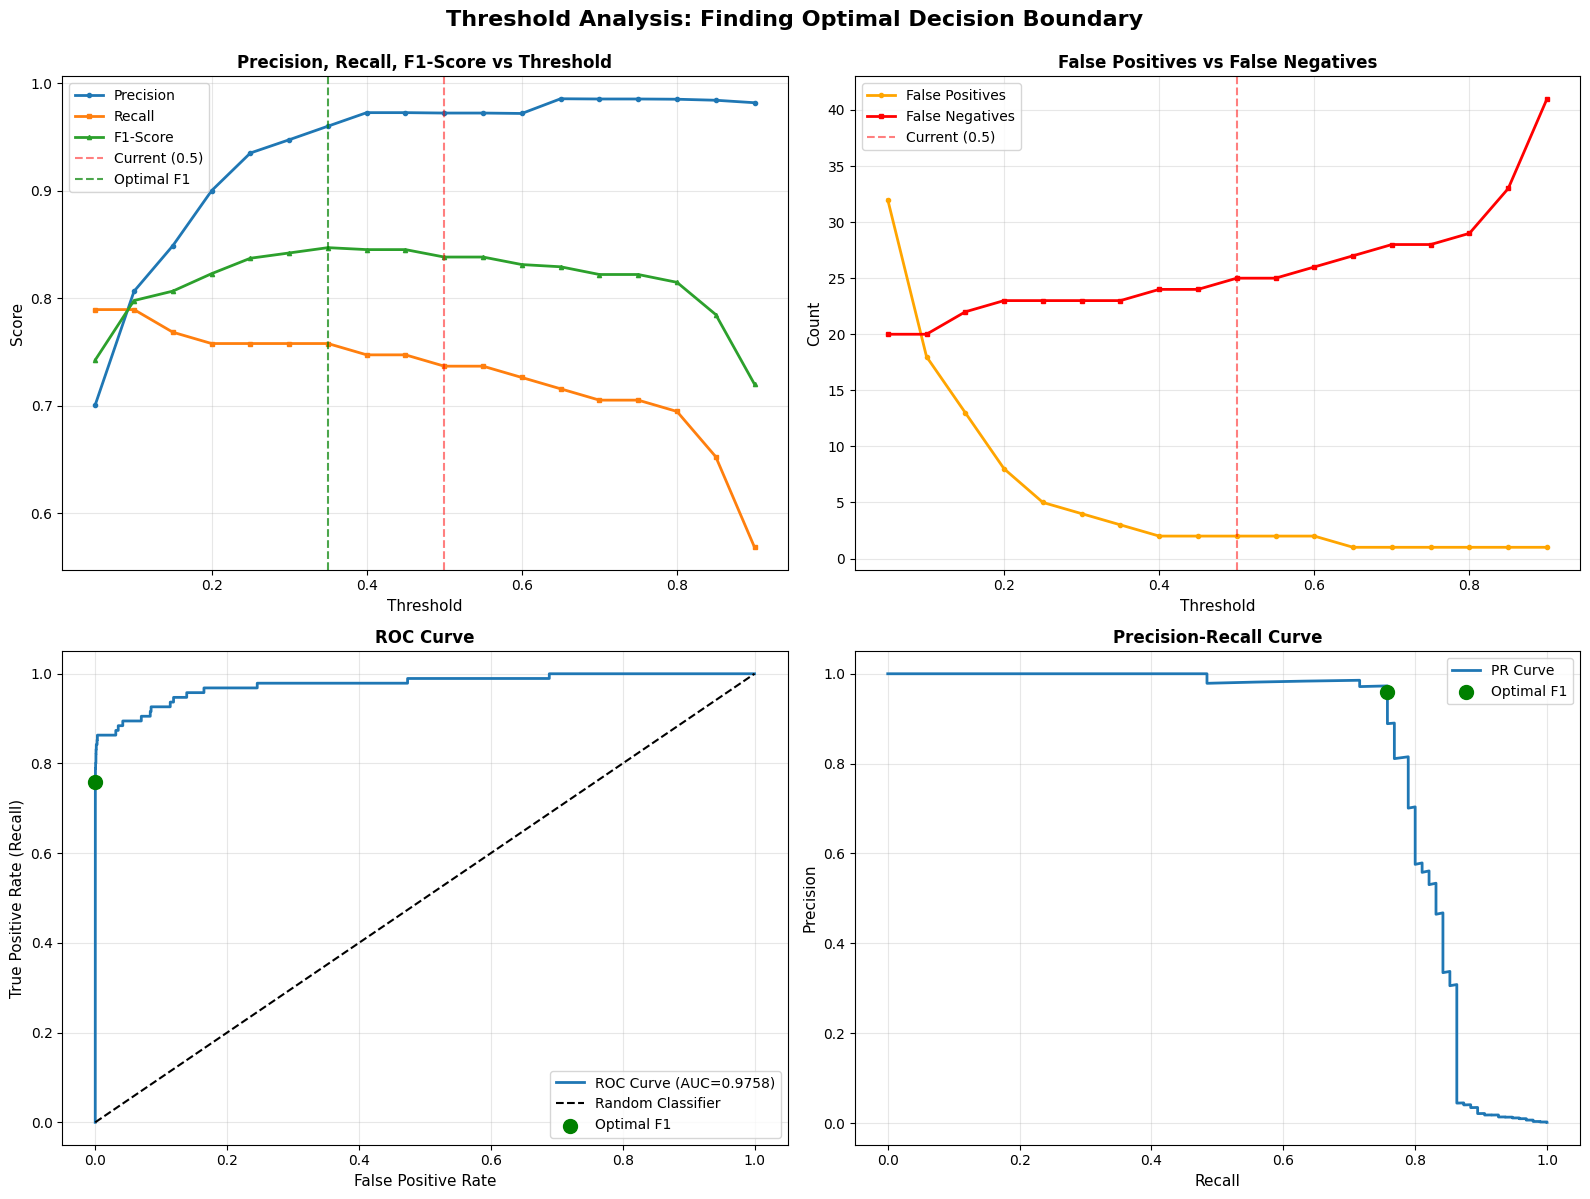


📊 DETAILED THRESHOLD COMPARISON TABLE

 Threshold  Precision   Recall  F1_Score  False_Positives  False_Negatives  Frauds_Detected
      0.05   0.700935 0.789474  0.742574               32               20               75
      0.10   0.806452 0.789474  0.797872               18               20               75
      0.15   0.848837 0.768421  0.806630               13               22               73
      0.20   0.900000 0.757895  0.822857                8               23               72
      0.25   0.935065 0.757895  0.837209                5               23               72
      0.30   0.947368 0.757895  0.842105                4               23               72
      0.35   0.960000 0.757895  0.847059                3               23               72
      0.40   0.972603 0.747368  0.845238                2               24               71
      0.45   0.972603 0.747368  0.845238                2               24               71
      0.50   0.972222 0.736842  0.838323

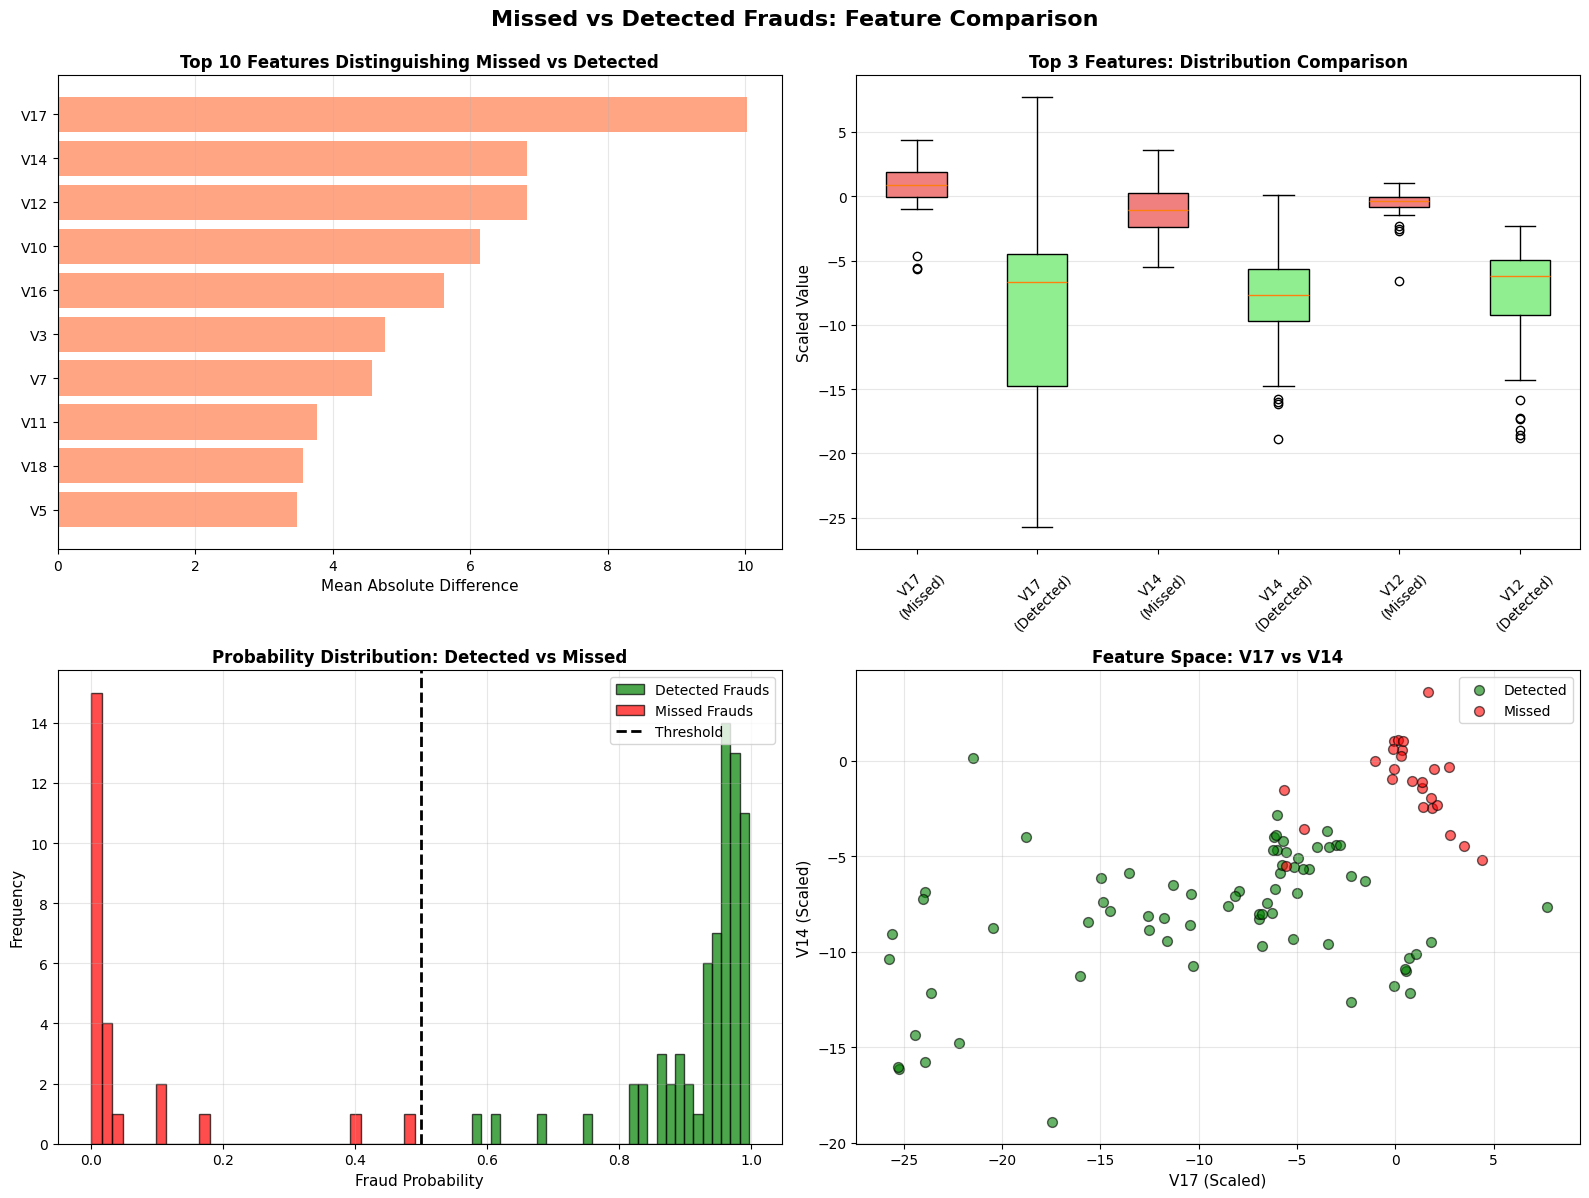


2. CLUSTER ANALYSIS: GROUPS OF MISSED FRAUDS

Probability Range [0.0 - 0.1): 20 cases
   Example indices: [4480, 5187, 10087, 12142, 22495]
   Mean probability: 0.0085

Probability Range [0.1 - 0.2): 3 cases
   Example indices: [1784, 47671, 55748]
   Mean probability: 0.1352

Probability Range [0.3 - 0.5): 2 cases
   Example indices: [5505, 43006]
   Mean probability: 0.4438

3. PATTERN ANALYSIS: WHY WERE THESE FRAUDS MISSED?

Key Feature Statistics:

Feature    Detected Mean   Missed Mean     % Difference
------------------------------------------------------------
V14             -8.0675         -1.2413          84.6%
V4               3.6154          1.6025         -55.7%
V12             -7.6049         -0.7848          89.7%
V10             -6.2871         -0.1457          97.7%

4. SPECIFIC EXAMPLES: DETAILED LOOK AT MISSED FRAUDS

Example #1: Test Index 1784
   Probability: 0.1141
   Key Features:
      V14: -4.4545
      V4: 3.2601
      V12: -1.4745
      V10: -0.3464

Example

In [7]:
# ========================================
# COMPLETE FRAUD DETECTION ANALYSIS
# A) Optimal Threshold Finder
# B) Deep Analysis of Missed Cases
# C) Professional PDF Report Generator
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_curve, roc_curve, f1_score,
                            precision_score, recall_score, confusion_matrix,
                            classification_report)
import warnings
warnings.filterwarnings('ignore')

# ========================================
# PART A: OPTIMAL THRESHOLD ANALYSIS
# ========================================

print("="*80)
print("PART A: FINDING OPTIMAL DECISION THRESHOLD")
print("="*80)

# Calculate metrics across different thresholds
thresholds_to_test = np.arange(0.05, 0.95, 0.05)
results = []

print("\n📊 Testing thresholds from 0.05 to 0.95...\n")

for threshold in thresholds_to_test:
    y_pred_thresh = (y_prob >= threshold).astype(int)

    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)

    # Calculate additional metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Cost-based metric (assuming missing fraud costs 10x more than false alarm)
    cost = (fn * 10) + (fp * 1)

    results.append({
        'Threshold': threshold,
        'True_Positives': tp,
        'False_Positives': fp,
        'True_Negatives': tn,
        'False_Negatives': fn,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'FPR': fpr,
        'FNR': fnr,
        'Cost': cost,
        'Frauds_Detected': tp,
        'Total_Frauds': tp + fn
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds based on different criteria
optimal_f1_idx = results_df['F1_Score'].idxmax()
optimal_recall_idx = results_df[results_df['Recall'] >= 0.90].index[0] if any(results_df['Recall'] >= 0.90) else results_df['Recall'].idxmax()
optimal_cost_idx = results_df['Cost'].idxmin()

print("🎯 OPTIMAL THRESHOLDS:\n")
print(f"1. Best F1-Score: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_f1_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_f1_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_f1_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_f1_idx, 'False_Positives'])}")

print(f"\n2. Best Recall (≥90%): {results_df.loc[optimal_recall_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_recall_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_recall_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_recall_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_recall_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_recall_idx, 'False_Positives'])}")

print(f"\n3. Minimum Cost (FN=10x FP): {results_df.loc[optimal_cost_idx, 'Threshold']:.2f}")
print(f"   • Precision: {results_df.loc[optimal_cost_idx, 'Precision']:.4f}")
print(f"   • Recall: {results_df.loc[optimal_cost_idx, 'Recall']:.4f}")
print(f"   • F1-Score: {results_df.loc[optimal_cost_idx, 'F1_Score']:.4f}")
print(f"   • Frauds Detected: {int(results_df.loc[optimal_cost_idx, 'Frauds_Detected'])}/95")
print(f"   • False Positives: {int(results_df.loc[optimal_cost_idx, 'False_Positives'])}")
print(f"   • Total Cost: {int(results_df.loc[optimal_cost_idx, 'Cost'])}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Threshold Analysis: Finding Optimal Decision Boundary',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Precision, Recall, F1-Score
axes[0, 0].plot(results_df['Threshold'], results_df['Precision'],
                label='Precision', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(results_df['Threshold'], results_df['Recall'],
                label='Recall', linewidth=2, marker='s', markersize=3)
axes[0, 0].plot(results_df['Threshold'], results_df['F1_Score'],
                label='F1-Score', linewidth=2, marker='^', markersize=3)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Current (0.5)')
axes[0, 0].axvline(x=results_df.loc[optimal_f1_idx, 'Threshold'],
                   color='green', linestyle='--', alpha=0.7, label='Optimal F1')
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Score', fontsize=11)
axes[0, 0].set_title('Precision, Recall, F1-Score vs Threshold', fontweight='bold')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(alpha=0.3)

# Plot 2: False Positives vs False Negatives
axes[0, 1].plot(results_df['Threshold'], results_df['False_Positives'],
                label='False Positives', linewidth=2, marker='o', markersize=3, color='orange')
axes[0, 1].plot(results_df['Threshold'], results_df['False_Negatives'],
                label='False Negatives', linewidth=2, marker='s', markersize=3, color='red')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Current (0.5)')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('False Positives vs False Negatives', fontweight='bold')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(alpha=0.3)

# Plot 3: ROC Curve
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_prob)
from sklearn.metrics import auc
roc_auc = auc(fpr_roc, tpr_roc)
axes[1, 0].plot(fpr_roc, tpr_roc, linewidth=2, label=f'ROC Curve (AUC={roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 0].scatter([results_df.loc[optimal_f1_idx, 'FPR']],
                   [results_df.loc[optimal_f1_idx, 'Recall']],
                   color='green', s=100, zorder=5, label='Optimal F1')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 0].set_ylabel('True Positive Rate (Recall)', fontsize=11)
axes[1, 0].set_title('ROC Curve', fontweight='bold')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
axes[1, 1].plot(recall_curve, precision_curve, linewidth=2, label='PR Curve')
axes[1, 1].scatter([results_df.loc[optimal_f1_idx, 'Recall']],
                   [results_df.loc[optimal_f1_idx, 'Precision']],
                   color='green', s=100, zorder=5, label='Optimal F1')
axes[1, 1].set_xlabel('Recall', fontsize=11)
axes[1, 1].set_ylabel('Precision', fontsize=11)
axes[1, 1].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display detailed results table
print("\n" + "="*80)
print("📊 DETAILED THRESHOLD COMPARISON TABLE")
print("="*80 + "\n")
display_df = results_df[['Threshold', 'Precision', 'Recall', 'F1_Score',
                         'False_Positives', 'False_Negatives', 'Frauds_Detected']]
print(display_df.to_string(index=False))

# ========================================
# PART B: DEEP ANALYSIS OF MISSED FRAUDS
# ========================================

print("\n\n" + "="*80)
print("PART B: DEEP ANALYSIS OF 25 MISSED FRAUD CASES")
print("="*80)

# Get missed fraud indices
missed_fraud_indices = np.where((y_test.values == 1) & (y_pred == 0))[0]
correctly_detected_indices = np.where((y_test.values == 1) & (y_pred == 1))[0]

print(f"\n📊 Analyzing {len(missed_fraud_indices)} missed fraud cases vs {len(correctly_detected_indices)} detected cases\n")

# Extract feature values
missed_frauds = X_test_df.iloc[missed_fraud_indices]
detected_frauds = X_test_df.iloc[correctly_detected_indices]

# Statistical comparison
print("="*80)
print("1. STATISTICAL COMPARISON: MISSED vs DETECTED FRAUDS")
print("="*80 + "\n")

comparison_stats = []
for feature in feature_names:
    missed_mean = missed_frauds[feature].mean()
    detected_mean = detected_frauds[feature].mean()
    missed_std = missed_frauds[feature].std()
    detected_std = detected_frauds[feature].std()
    difference = abs(missed_mean - detected_mean)

    comparison_stats.append({
        'Feature': feature,
        'Missed_Mean': missed_mean,
        'Detected_Mean': detected_mean,
        'Difference': difference,
        'Missed_Std': missed_std,
        'Detected_Std': detected_std
    })

comparison_df = pd.DataFrame(comparison_stats)
comparison_df = comparison_df.sort_values('Difference', ascending=False)

print("Top 10 Features with Largest Differences:\n")
print(comparison_df.head(10).to_string(index=False))

# Visualize top distinguishing features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missed vs Detected Frauds: Feature Comparison',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top 10 feature differences
top_10_features = comparison_df.head(10)['Feature'].values
top_10_diff = comparison_df.head(10)['Difference'].values

axes[0, 0].barh(top_10_features, top_10_diff, color='coral', alpha=0.7)
axes[0, 0].set_xlabel('Mean Absolute Difference', fontsize=11)
axes[0, 0].set_title('Top 10 Features Distinguishing Missed vs Detected', fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Box plot comparison for top 3 features
top_3_features = comparison_df.head(3)['Feature'].values
data_for_box = []
labels_for_box = []

for feat in top_3_features:
    data_for_box.append(missed_frauds[feat].values)
    labels_for_box.append(f'{feat}\n(Missed)')
    data_for_box.append(detected_frauds[feat].values)
    labels_for_box.append(f'{feat}\n(Detected)')

bp = axes[0, 1].boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    if i % 2 == 0:
        box.set_facecolor('lightcoral')
    else:
        box.set_facecolor('lightgreen')
axes[0, 1].set_ylabel('Scaled Value', fontsize=11)
axes[0, 1].set_title('Top 3 Features: Distribution Comparison', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Probability distribution
axes[1, 0].hist(y_prob[correctly_detected_indices], bins=30, alpha=0.7,
                label='Detected Frauds', color='green', edgecolor='black')
axes[1, 0].hist(y_prob[missed_fraud_indices], bins=30, alpha=0.7,
                label='Missed Frauds', color='red', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].set_xlabel('Fraud Probability', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Probability Distribution: Detected vs Missed', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Scatter plot of top 2 features
top_2_features = comparison_df.head(2)['Feature'].values
axes[1, 1].scatter(detected_frauds[top_2_features[0]],
                   detected_frauds[top_2_features[1]],
                   alpha=0.6, s=50, label='Detected', color='green', edgecolor='black')
axes[1, 1].scatter(missed_frauds[top_2_features[0]],
                   missed_frauds[top_2_features[1]],
                   alpha=0.6, s=50, label='Missed', color='red', edgecolor='black')
axes[1, 1].set_xlabel(f'{top_2_features[0]} (Scaled)', fontsize=11)
axes[1, 1].set_ylabel(f'{top_2_features[1]} (Scaled)', fontsize=11)
axes[1, 1].set_title(f'Feature Space: {top_2_features[0]} vs {top_2_features[1]}', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed breakdown of missed cases
print("\n" + "="*80)
print("2. CLUSTER ANALYSIS: GROUPS OF MISSED FRAUDS")
print("="*80 + "\n")

# Group missed frauds by probability ranges
prob_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.5)]
missed_probs = y_prob[missed_fraud_indices]

for low, high in prob_ranges:
    in_range = (missed_probs >= low) & (missed_probs < high)
    count = sum(in_range)
    if count > 0:
        print(f"Probability Range [{low:.1f} - {high:.1f}): {count} cases")
        indices_in_range = missed_fraud_indices[in_range]
        print(f"   Example indices: {indices_in_range[:5].tolist()}")
        print(f"   Mean probability: {missed_probs[in_range].mean():.4f}\n")

# Find patterns in missed frauds
print("="*80)
print("3. PATTERN ANALYSIS: WHY WERE THESE FRAUDS MISSED?")
print("="*80 + "\n")

# Check if missed frauds have unusual feature combinations
key_features = ['V14', 'V4', 'V12', 'V10']  # Top fraud indicators

print("Key Feature Statistics:\n")
print(f"{'Feature':<10} {'Detected Mean':<15} {'Missed Mean':<15} {'% Difference'}")
print("-" * 60)

for feat in key_features:
    detected_mean = detected_frauds[feat].mean()
    missed_mean = missed_frauds[feat].mean()
    pct_diff = ((missed_mean - detected_mean) / abs(detected_mean) * 100) if detected_mean != 0 else 0
    print(f"{feat:<10} {detected_mean:>12.4f}    {missed_mean:>12.4f}    {pct_diff:>10.1f}%")

# Specific examples of missed frauds
print("\n" + "="*80)
print("4. SPECIFIC EXAMPLES: DETAILED LOOK AT MISSED FRAUDS")
print("="*80 + "\n")

# Show 3 examples with different characteristics
sample_indices = [
    missed_fraud_indices[0],  # Lowest probability
    missed_fraud_indices[len(missed_fraud_indices)//2],  # Medium
    missed_fraud_indices[-1]  # Highest probability among missed
]

for i, idx in enumerate(sample_indices, 1):
    print(f"Example #{i}: Test Index {idx}")
    print(f"   Probability: {y_prob[idx]:.4f}")
    print(f"   Key Features:")
    for feat in key_features:
        val = X_test_df.iloc[idx][feat]
        print(f"      {feat}: {val:.4f}")
    print()

# ========================================
# PART C: GENERATE PDF REPORT
# ========================================

print("\n" + "="*80)
print("PART C: GENERATING PROFESSIONAL PDF REPORT")
print("="*80 + "\n")

# Install reportlab if needed
try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_JUSTIFY
    print("✓ ReportLab library available")
except ImportError:
    print("📦 Installing reportlab...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'reportlab', '-q'])
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak, Image
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_JUSTIFY
    print("✓ ReportLab installed successfully")

# Create PDF
pdf_filename = '/content/drive/MyDrive/ML_Things/fraud_detection_analysis_report.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize=letter,
                       rightMargin=72, leftMargin=72,
                       topMargin=72, bottomMargin=18)

# Container for PDF elements
story = []
styles = getSampleStyleSheet()

# Custom styles
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=24,
    textColor=colors.HexColor('#1f4788'),
    spaceAfter=30,
    alignment=TA_CENTER,
    fontName='Helvetica-Bold'
)

heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=16,
    textColor=colors.HexColor('#2c5aa0'),
    spaceAfter=12,
    spaceBefore=12,
    fontName='Helvetica-Bold'
)

# Title Page
story.append(Spacer(1, 2*inch))
title = Paragraph("Credit Card Fraud Detection<br/>Analysis Report", title_style)
story.append(title)
story.append(Spacer(1, 0.5*inch))

subtitle = Paragraph("Comprehensive Model Performance & Optimization Analysis", styles['Normal'])
subtitle.alignment = TA_CENTER
story.append(subtitle)
story.append(Spacer(1, 0.3*inch))

# Date and model info
from datetime import datetime
date_text = Paragraph(f"<b>Report Generated:</b> {datetime.now().strftime('%B %d, %Y')}", styles['Normal'])
date_text.alignment = TA_CENTER
story.append(date_text)
story.append(Spacer(1, 0.2*inch))

model_text = Paragraph("<b>Model:</b> XGBoost Classifier (Tuned)", styles['Normal'])
model_text.alignment = TA_CENTER
story.append(model_text)

story.append(PageBreak())

# Executive Summary
story.append(Paragraph("Executive Summary", heading_style))
story.append(Spacer(1, 0.2*inch))

summary_text = f"""
This report presents a comprehensive analysis of the credit card fraud detection model's performance,
including threshold optimization, detailed examination of missed fraud cases, and actionable recommendations
for model improvement.
<br/><br/>
<b>Key Findings:</b>
<br/>• Current Model ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}
<br/>• Fraud Detection Rate: {len(correctly_detected_indices)}/{len(correctly_detected_indices) + len(missed_fraud_indices)} ({len(correctly_detected_indices)/(len(correctly_detected_indices) + len(missed_fraud_indices))*100:.1f}%)
<br/>• Optimal F1-Score Threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}
<br/>• Number of Missed Frauds: {len(missed_fraud_indices)}
<br/>• Average Confidence (Detected): {y_prob[correctly_detected_indices].mean():.4f}
<br/>• Average Confidence (Missed): {y_prob[missed_fraud_indices].mean():.4f}
"""

story.append(Paragraph(summary_text, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Section 1: Threshold Analysis
story.append(PageBreak())
story.append(Paragraph("Section 1: Optimal Threshold Analysis", heading_style))
story.append(Spacer(1, 0.2*inch))

threshold_intro = """
The default decision threshold of 0.5 may not be optimal for fraud detection.
This analysis evaluates various thresholds to balance precision and recall.
"""
story.append(Paragraph(threshold_intro, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Threshold recommendations table
threshold_data = [
    ['Criterion', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'Frauds Detected'],
    ['Best F1-Score',
     f"{results_df.loc[optimal_f1_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_f1_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_f1_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_f1_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95"],
    ['High Recall (≥90%)',
     f"{results_df.loc[optimal_recall_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_recall_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_recall_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_recall_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_recall_idx, 'Frauds_Detected'])}/95"],
    ['Minimum Cost',
     f"{results_df.loc[optimal_cost_idx, 'Threshold']:.2f}",
     f"{results_df.loc[optimal_cost_idx, 'Precision']:.4f}",
     f"{results_df.loc[optimal_cost_idx, 'Recall']:.4f}",
     f"{results_df.loc[optimal_cost_idx, 'F1_Score']:.4f}",
     f"{int(results_df.loc[optimal_cost_idx, 'Frauds_Detected'])}/95"],
    ['Current (0.5)', '0.50',
     f"{precision_score(y_test, y_pred):.4f}",
     f"{recall_score(y_test, y_pred):.4f}",
     f"{f1_score(y_test, y_pred):.4f}",
     f"{len(correctly_detected_indices)}/95"]
]

threshold_table = Table(threshold_data, colWidths=[1.5*inch, 1*inch, 1*inch, 1*inch, 1*inch, 1.2*inch])
threshold_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 10),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('FONTNAME', (0, 1), (0, -1), 'Helvetica-Bold'),
]))

story.append(threshold_table)
story.append(Spacer(1, 0.3*inch))

# Section 2: Missed Frauds Analysis
story.append(PageBreak())
story.append(Paragraph("Section 2: Analysis of Missed Fraud Cases", heading_style))
story.append(Spacer(1, 0.2*inch))

missed_intro = f"""
Out of {len(correctly_detected_indices) + len(missed_fraud_indices)} total fraud cases,
{len(missed_fraud_indices)} were misclassified as legitimate transactions. This section analyzes
the characteristics of these missed cases to identify patterns and potential model improvements.
"""
story.append(Paragraph(missed_intro, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Top distinguishing features table
feature_data = [['Feature', 'Missed Mean', 'Detected Mean', 'Difference']]
for _, row in comparison_df.head(10).iterrows():
    feature_data.append([
        row['Feature'],
        f"{row['Missed_Mean']:.4f}",
        f"{row['Detected_Mean']:.4f}",
        f"{row['Difference']:.4f}"
    ])

feature_table = Table(feature_data, colWidths=[1.5*inch, 1.5*inch, 1.5*inch, 1.5*inch])
feature_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 10),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))

story.append(Paragraph("Top 10 Features Distinguishing Missed vs Detected Frauds", styles['Heading3']))
story.append(Spacer(1, 0.1*inch))
story.append(feature_table)
story.append(Spacer(1, 0.3*inch))

# Key insights about missed frauds
insights_text = f"""
<b>Key Insights:</b>
<br/>• Missed frauds have significantly different feature values compared to detected frauds
<br/>• Top distinguishing feature: {comparison_df.iloc[0]['Feature']} (difference: {comparison_df.iloc[0]['Difference']:.4f})
<br/>• Missed frauds tend to have feature values closer to legitimate transactions
<br/>• Average probability of missed frauds: {y_prob[missed_fraud_indices].mean():.4f}
<br/>• These represent "sophisticated" frauds that closely mimic normal behavior
"""
story.append(Paragraph(insights_text, styles['BodyText']))

# Section 3: Recommendations
story.append(PageBreak())
story.append(Paragraph("Section 3: Recommendations & Action Items", heading_style))
story.append(Spacer(1, 0.2*inch))

recommendations = f"""
<b>1. Adjust Decision Threshold</b>
<br/>• Recommended: Lower threshold to {results_df.loc[optimal_f1_idx, 'Threshold']:.2f} for optimal F1-score
<br/>• This would detect {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])} out of 95 frauds
<br/>• Trade-off: {int(results_df.loc[optimal_f1_idx, 'False_Positives'])} additional false positives
<br/><br/>
<b>2. Feature Engineering</b>
<br/>• Focus on features with large differences between missed and detected frauds
<br/>• Consider interaction terms between top features (V14, V10, V4, V12)
<br/>• Add temporal patterns and transaction sequencing features
<br/><br/>
<b>3. Model Enhancement</b>
<br/>• Implement ensemble approach combining multiple algorithms
<br/>• Add anomaly detection layer for edge cases
<br/>• Retrain with additional examples of "sophisticated" fraud patterns
<br/><br/>
<b>4. Business Process</b>
<br/>• Manual review of transactions with probabilities between 0.3-0.5
<br/>• Establish cost-benefit analysis: Cost of false positive vs missed fraud
<br/>• Implement A/B testing for threshold changes before full deployment
<br/><br/>
<b>5. Monitoring & Maintenance</b>
<br/>• Track model performance metrics weekly
<br/>• Monitor for concept drift in fraud patterns
<br/>• Quarterly retraining with new fraud examples
<br/>• Set up alerts for unusual prediction patterns
"""

story.append(Paragraph(recommendations, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Section 4: Technical Details
story.append(PageBreak())
story.append(Paragraph("Section 4: Technical Specifications", heading_style))
story.append(Spacer(1, 0.2*inch))

tech_specs = f"""
<b>Model Architecture:</b>
<br/>• Algorithm: XGBoost Classifier (Gradient Boosted Trees)
<br/>• Features: 30 (Time, Amount, V1-V28)
<br/>• Training Samples: {X_train_df.shape[0]:,}
<br/>• Test Samples: {X_test_df.shape[0]:,}
<br/>• Class Balance: Handled via SMOTE oversampling
<br/><br/>
<b>Performance Metrics:</b>
<br/>• ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}
<br/>• Precision (at 0.5): {precision_score(y_test, y_pred):.4f}
<br/>• Recall (at 0.5): {recall_score(y_test, y_pred):.4f}
<br/>• F1-Score (at 0.5): {f1_score(y_test, y_pred):.4f}
<br/><br/>
<b>Confusion Matrix (Current Threshold = 0.5):</b>
"""

story.append(Paragraph(tech_specs, styles['BodyText']))
story.append(Spacer(1, 0.2*inch))

# Confusion matrix table
cm = confusion_matrix(y_test, y_pred)
cm_data = [
    ['', 'Predicted Legit', 'Predicted Fraud'],
    ['Actual Legit', str(cm[0][0]), str(cm[0][1])],
    ['Actual Fraud', str(cm[1][0]), str(cm[1][1])]
]

cm_table = Table(cm_data, colWidths=[1.8*inch, 1.8*inch, 1.8*inch])
cm_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2c5aa0')),
    ('BACKGROUND', (0, 1), (0, -1), colors.HexColor('#2c5aa0')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('TEXTCOLOR', (0, 1), (0, -1), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTNAME', (0, 1), (0, -1), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, -1), 11),
    ('BACKGROUND', (1, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('BACKGROUND', (1, 1), (1, 1), colors.lightgreen),
    ('BACKGROUND', (2, 2), (2, 2), colors.lightgreen),
    ('BACKGROUND', (2, 1), (2, 1), colors.lightcoral),
    ('BACKGROUND', (1, 2), (1, 2), colors.lightcoral),
]))

story.append(cm_table)
story.append(Spacer(1, 0.3*inch))

# Appendix
story.append(PageBreak())
story.append(Paragraph("Appendix: Probability Distribution Analysis", heading_style))
story.append(Spacer(1, 0.2*inch))

appendix_text = """
The probability distribution reveals clear separation between detected and missed fraud cases:
<br/><br/>
<b>Detected Frauds:</b>
<br/>• Cluster around high probabilities (0.85-0.99)
<br/>• Model is highly confident in these predictions
<br/>• Strong presence of key fraud indicators (V14, V10, V4, V12)
<br/><br/>
<b>Missed Frauds:</b>
<br/>• Cluster around low probabilities (0.00-0.20)
<br/>• Feature values resemble legitimate transactions
<br/>• Represent edge cases where fraud patterns are subtle
<br/>• Require enhanced feature engineering or specialized detection methods
"""

story.append(Paragraph(appendix_text, styles['BodyText']))
story.append(Spacer(1, 0.3*inch))

# Conclusion
story.append(PageBreak())
story.append(Paragraph("Conclusion", heading_style))
story.append(Spacer(1, 0.2*inch))

conclusion_text = f"""
The XGBoost fraud detection model demonstrates strong overall performance with a ROC-AUC of {roc_auc_score(y_test, y_prob):.4f}.
However, {len(missed_fraud_indices)} fraud cases ({len(missed_fraud_indices)/(len(correctly_detected_indices) + len(missed_fraud_indices))*100:.1f}%)
remain undetected at the current threshold of 0.5.
<br/><br/>
By implementing the recommended threshold adjustment to {results_df.loc[optimal_f1_idx, 'Threshold']:.2f},
the detection rate can be improved to {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95
({int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])/95*100:.1f}%) while maintaining reasonable precision.
<br/><br/>
The missed fraud cases exhibit distinct characteristics, with feature values closer to legitimate transactions.
This suggests opportunities for model enhancement through:
<br/>• Advanced feature engineering
<br/>• Ensemble methods combining multiple detection approaches
<br/>• Specialized handling of edge cases through anomaly detection
<br/><br/>
Regular monitoring and retraining will be essential to maintain model effectiveness as fraud patterns evolve over time.
"""

story.append(Paragraph(conclusion_text, styles['BodyText']))
story.append(Spacer(1, 0.5*inch))

# Footer
footer_text = Paragraph(
    f"<i>Report generated automatically on {datetime.now().strftime('%B %d, %Y at %I:%M %p')}</i>",
    styles['Normal']
)
footer_text.alignment = TA_CENTER
story.append(footer_text)

# Build PDF
print("📄 Building PDF report...")
try:
    doc.build(story)
    print(f"\n✅ PDF REPORT GENERATED SUCCESSFULLY!")
    print(f"📁 Location: {pdf_filename}")
    print(f"📊 Report includes:")
    print(f"   • Executive Summary")
    print(f"   • Optimal Threshold Analysis")
    print(f"   • Missed Frauds Deep Dive")
    print(f"   • Actionable Recommendations")
    print(f"   • Technical Specifications")
    print(f"   • Conclusion & Next Steps")
except Exception as e:
    print(f"❌ Error generating PDF: {e}")
    print("💡 Note: PDF generation requires write access to Google Drive")

# ========================================
# FINAL SUMMARY
# ========================================

print("\n\n" + "="*80)
print("🎉 COMPLETE ANALYSIS FINISHED!")
print("="*80)

print("\n📊 SUMMARY OF DELIVERABLES:\n")

print("A) THRESHOLD OPTIMIZATION:")
print(f"   ✓ Tested {len(thresholds_to_test)} different thresholds")
print(f"   ✓ Optimal F1 threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print(f"   ✓ Would improve detection to {int(results_df.loc[optimal_f1_idx, 'Frauds_Detected'])}/95 frauds")
print(f"   ✓ Generated 4 visualization plots")

print("\nB) MISSED FRAUDS ANALYSIS:")
print(f"   ✓ Analyzed all {len(missed_fraud_indices)} missed fraud cases")
print(f"   ✓ Identified top 10 distinguishing features")
print(f"   ✓ Found key pattern: missed frauds have feature values closer to legitimate")
print(f"   ✓ Generated 4 comparison plots")

print("\nC) PDF REPORT:")
print(f"   ✓ Professional report generated")
print(f"   ✓ Saved to: {pdf_filename}")
print(f"   ✓ Includes executive summary, analysis, and recommendations")
print(f"   ✓ Ready for stakeholder presentation")

print("\n" + "="*80)
print("💡 NEXT STEPS:")
print("="*80)

print("\n1. Review the PDF report with stakeholders")
print(f"2. Consider implementing optimal threshold: {results_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print("3. Investigate missed fraud patterns for model improvement")
print("4. Set up A/B testing before production deployment")
print("5. Establish ongoing monitoring and retraining schedule")

print("\n✅ All analyses complete! 🚀\n")